# 2D Keypoint Detection of Shoes - Marco   
Detecting/Regressing the keypoints of shoes from 2D images. including keypoint of toe end, heel end, topline, inside and outside. 

## $\color{red}{TODO}$  
* ~~Test~~
* ~~Check and finetune the labels~~
* ~~Read the json file or write labels into a spreadsheet~~
* ~~Limit the range of normalized labels (sometimes may out of (0,1): keep (0,0) when confidence ==0; aviod negative value like -3.8435854e-04 by RandomPad, which is close to 0 and caused by rotation.~~
* ~~Transform TrainingSet and ValidationSet~~
* ~~Replace arbitrary background (instead of black) with random color (b,g,r)~~
* ~~Augment the images with multiple points. -  Improve transforms.py and functional.py~~
* ~~RandomPadWithPoints~~
* RandomResizedCropWithPoints
* ~~Does Shuffle=True in dataloader cause any problems? - No, it doesn't~~
* ~~Try to regress coordiante values with confidence as (x,y,confidence)~~
    * coordinate loss = 0.5 * MSE Loss + 0.5 * Euclidean Distance  
    * confidence loss
        * thresh=0.5, if predicted_confidence < thresh
    * Loss = 0.5 * coordinate loss + 0.5 confidence loss
    * Don't calculate loss when labelled keypoints is not existing (labelled confidence ==0) - can it backward? Yes
* 验证 coordinates + confidence代码的正确性 （Loss计算）
* ~~RandomPad TestingSet~~
* Try heatmaps methods
    * Initialize the weights or **not**  
        * nn.initializer.KaimingNormal(), nn.initializer.Normal()
        * nn.initializer.KaimingUniform(), nn.initializer.Uniform()
    * L1 Loss & **MSE (L2) Loss**
    * GResNet channel size =32, 64, and make it deeper
    * With & without Dropout & different dropout probabilities (0.4 & 0.1)
    * ~~Pad Testing Set randomly (trans.RandomPadWithPoints(pad_thresh_l=0.316, pad_thresh_h=0.412) or consistently (pad_thresh_l=0.400, pad_thresh_h=0.400) ~~
    * GResNet & UNet 
    * HRNet https://www.paddlepaddle.org.cn/tutorials/projectdetail/2538217#anchor-10
    * Stacked Hourglass 
    * smaller Gaussian kernel
* Per-point loss and euclidean distance   
* ~~Don't use random pad to avoid noise~~
* **Tranfer Learning or feature extraction (freeze) from ResNet34 used in ShoePoseDetection (try both regression and heatmap method)** 
* ~~**Label almost all of the keypoints for shoes in each pose**~~
* Model ensemble for heatmap method
    * With & without Dropout & different dropout probabilities
    * different params (pad_thresh_l, pad_thresh_h) in RandomPadWithPoints
    * different weights initialization method
* Try heatmaps + coordinates offsets
* do sth when self.mode == 'test':
* Training on TrainingSet + ValidationSet, fine-tuning on TestingSet,and Selecting the best model according to TestingSet
* Cleaning the data, low intra-class invariance is expected; collect more data by KPAM method
* Try 3D Keypoint Detection
* coordinate Loss = 0.5 * MSE Loss + 0.5 * Euclidean Distance
* Metric: average ED
* Framework: Paddle 2.2.1 or Paddle 2.0.2
* ~~Visualize the predicted results - see Evaluation and Visualization~~
* Combining the prior knowledge acquired from Shoe Pose Classification
* If we could predict points with really high confidence, try to predict Shoes'pose by keypoints.
* combine Data Augmentation with one point and multiple points by     
considering the confidence  
if isinstance(degrees, numbers.Number):  
....  
else:  
....len(degrees)   

## Output  
1. **Regressing coordinate value** FC layer,number of output neutrons = 2n, n is the total number of keypoints 
    1.9 References
        DeepPose: Human Pose Estimation via Deep Neural Networks
2. **Heatmaps** (n, output_imagesize, output_imagesize), then map into original images.  
    2.0 Input Gaussian Mixture Models with keypoints  
    2.1 confidence/score threshold, ignore the maps with low score   
    2.2 Network Architecture: HRNet, U-CoTNet, stacked hourglass, 增加结构促进空间上下文相互学习
    2.3 Loss: MSE, MSE+Euclidean distance, smoothed L2 loss, L2 Loss + ED,CE Loss
    
    2.4 metrics: pixel-wise, keypoint-wise
    2.7 Post-processing, linear mapping, NMS或动态规划算法  
    2.8 Reasons for using heatmap as outputs  
        1) 直接让网络输出二维坐标来进行优化学习是一个极其非线性的过程，收敛难度大  
        2) 损失函数对权重的约束比较弱。构造heatmap实际上是构造了一个中间状态。
        3) keypoints之间存在几何关系。单独的对每一类关节点回归坐标值并不能捕捉利用这些相关关系，当回归heatmap时，一张输入图像对应的heatmaps就存在这种相关关系，那就可以用来指导网络进行学习。
        4) heatmap同样捕捉了keypoints 与background的对比关系，同样可以用来指导网络进行学习
        5) heatmap 方法类似于对回归坐标值的方法 进行one-hot编码，解空间更小。 
        6) 相对regression方法不容易过拟合，
    2.9 Disadvantages and solutions
        1) 模型更复杂，较难训练。由于heatmap是从GMM后的输入heatmap图片到预测的heatmap（像素级）, 而regression是直接从图片到坐标值， 所以heatmap相对不相干的异常值更敏感。  
        2) 损失函数往往没用同“关键点坐标的量化数值”建立比较直接的关系, 换句话说模型是非end-to-end，进而直接影响了梯度的flow。参考 Numerical Coordinate Regression with Convolutional Neural Networks，
    2.10 References
        Joint Training of a Convolutional Network and a Graphical Model for Human Pose Estimation  



## Deal With Unequal number of keypoints  
1. Regression method with confidence
2. Heatmap method with keypoint score (the value at each pixel) threshold.- unify the pixel values of ground-truth non-keypoint heatmap.
3. Referring to YOLO, output (x,y,confidence,class * 5) * number of (points) anchors
4. Combining the prior knowledge acquired from Shoe Pose Classification: predicting 2,3,4 keypoints for shoe in bottom, side, top pose respectively.


In [ ]:
!unzip -o data/data127118/ShoesKeypoints.zip  -d /home/aistudio/

In [15]:
### Process json files
import os
import json
trainset_root = 'test'
# trainset_root = 'ShoesKeypoints/TrainingSet'
# valset_root = 'ShoesKeypoints/ValidationSet'
train_filelists = os.listdir(trainset_root)   # list the child directories of the trainset_root
# val_filelists = os.listdir(valset_root)
# print("Total Nums: {}, train: {}, val: {}".format(len(train_filelists)+len(val_filelists), len(train_filelists), len(val_filelists)))
for l in train_filelists:
    with open(os.path.join(trainset_root,l),'r',encoding='utf8') as lb:
        lb_json = json.load(lb)
        print(lb_json)
        for s in lb_json['shapes']:
            print(s['points'][0])



{'version': '4.6.0', 'flags': {}, 'shapes': [{'label': 'toe_end', 'points': [[17.188976377952756, 579.5275590551181]], 'group_id': None, 'shape_type': 'point', 'flags': {}}, {'label': 'heel_end', 'points': [[991.992125984252, 567.7165354330708]], 'group_id': None, 'shape_type': 'point', 'flags': {}}, {'label': 'topline1', 'points': [[551.0472440944882, 327.5590551181102]], 'group_id': None, 'shape_type': 'point', 'flags': {}}], 'imagePath': '124403w-bbk-sbgow__3.jpg', 'imageData': None, 'imageHeight': 1024, 'imageWidth': 1024}
[17.188976377952756, 579.5275590551181]
[991.992125984252, 567.7165354330708]
[551.0472440944882, 327.5590551181102]
{'version': '4.6.0', 'flags': {}, 'shapes': [{'label': 'heel_end', 'points': [[33.10344827586207, 562.7586206896552]], 'group_id': None, 'shape_type': 'point', 'flags': {}}, {'label': 'toe_end', 'points': [[1003.448275862069, 576.551724137931]], 'group_id': None, 'shape_type': 'point', 'flags': {}}, {'label': 'topline1', 'points': [[468.27586206896

## Config

In [3]:
!nvidia-smi

In [2]:
### import the necessary packages

import sys 
sys.path.append('/home/aistudio/external-libraries')
import os
import cv2
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances 
from sklearn.metrics import cohen_kappa_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
import matplotlib.pylab as plt

import paddle
import paddle.nn as nn
from paddle.vision.models import resnet50, resnet101, resnet152
from paddle.io import Dataset
import transforms as trans 
import functional as F
import logging 
from datetime import datetime


In [3]:
### set the parameters in your framework
image_size = 512 # the image size to the network (image_size, image_size, 3)
batchsize = 8  # batch size
iters = 20000 # training iteration
optimizer_type = 'adam' # the optimizer, can be set as SGD, RMSprop,...
num_workers = 8 # Number of workers used to load data
init_lr = 1e-3 # the initial learning rate 1e-4

label_file =  'ShoesKeypointsGT_more.xls' # 'ShoesKeypointsGT.xls'
trainset_root = "TrainingSet"  
valset_root = "ValidationSet" # ValidationSet
testset_root = "TestingSet"
train_filelists = [os.path.join(trainset_root, i) for i in os.listdir(trainset_root)]  # list the child directories of the trainset_root
val_filelists = [os.path.join(valset_root,i) for i in  os.listdir(valset_root)]
test_filelists = [os.path.join(testset_root,i) for i in os.listdir(testset_root)]
train_val_filelists = train_filelists + val_filelists
train_val_test_filelists = train_filelists + val_filelists + test_filelists
print("Total Nums: {}, train: {}, val: {}, train+val: {} Test: {}".format(len(train_val_test_filelists ), len(train_filelists), len(val_filelists), len(train_val_filelists),len(test_filelists)))


Total Nums: 557, train: 224, val: 143, train+val: 367 Test: 190


In [4]:
print(val_filelists[3])
print(val_filelists[3].split('/')[-1]) 
# print(train_filelists.index('TrainingSet/1855211-405__3.jpg'))
# print(val_filelists.index('ValidationSet/wolve809404_441350_hd2.jpg'))
print(test_filelists.index('TestingSet/IMG_20211207_113642.jpg'))
print(test_filelists.index('TestingSet/IMG_20211207_113724.jpg'))
print(test_filelists.index('TestingSet/IMG_20211207_113811.jpg'))

ValidationSet/thecl690630_11493_hd3.jpg
thecl690630_11493_hd3.jpg
151
135
184


# Regression Method

## DataLoader

In [4]:
### Class Dataset of the first network
### load the img images from the data folder, 
### and extract the corresponding ground truth to generate training samples
class imgDataset(Dataset):
    def __init__(self,  image_file, label_file=None, img_transforms=None,filelists=None,  mode='train'):
        super(imgDataset, self).__init__()
        self.img_transforms =  img_transforms
        self.mode = mode.lower()
        self.image_path = image_file
        # image_idxs = os.listdir(self.image_path)
        image_idxs = self.image_path   # the list of img images' path
        self.label_file = label_file
        # self.crop=crop

        if self.mode == 'train':
            label = {row['img_name']: row[1:].values 
                        for _, row in pd.read_excel(label_file).iterrows()}
            self.file_list = [[image_idxs[i], label[image_idxs[i].split('/')[-1]]] for i in range(len(image_idxs))] # split('/')[-1][:-4]
            # print(self.file_list)

        elif self.mode == 'test':
            self.file_list = [[image_idxs[i], None] for i in range(len(image_idxs))]
        
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item[0] in filelists] 
   
    def __getitem__(self, idx):
        real_index, label = self.file_list[idx]
        img_path = real_index    # real_index = absolute path of imgs 
        img = cv2.imread(img_path)[:, :, ::-1] # BGR -> RGB        
        h,w,c = img.shape   # h,w,c is the original shape

        fh, fw = h,w

        if self.mode == 'train':
            confidence= (float(label[0]), float(label[3]), float(label[6]), float(label[9]) , float(label[12]))
            x         = (float(label[1]), float(label[4]), float(label[7]), float(label[10]), float(label[13]))  # 
            y         = (float(label[2]), float(label[5]), float(label[8]), float(label[11]), float(label[14]))
            fx = x
            fy = y

            # Normalization
            label_nor = (tuple(fi/fw for fi in fx), tuple(fj/fh for fj in fy))  
            label_nor = np.array(label_nor).astype('float32').reshape(2,5)  # from tuple to np.array
            confidence= np.array(confidence).astype('float32').reshape(5)
            
        
        # Resize
        # img = cv2.resize(img,(image_size, image_size))
        
        # Data Augmengtation
        if self.img_transforms is not None:
            # Data Augmentation with multiple points, label_nor[0] is a 1x5 np.ndarray, which is changeable
            img_re, label_nor[0], label_nor[1]= self.img_transforms(img, label_nor[0], label_nor[1],confidence)

            img_re = cv2.resize(img_re,(image_size, image_size)) # ignore it when we use RandomResizedCrop
        img = img_re.transpose(2, 0, 1) # H, W, C -> C, H, W
        # img = img_re.astype(np.float32)

        label_nor = label_nor.reshape(10, order ='F') # reshape to a 1x10 ndarray [toe_end_x, toe_end_y, heel_end_x, heel_end_y ...] 
        label_nor =  np.append(label_nor, confidence) # regress coordinates with confidence, 0-9 are coordinates, 10-14 are confidences

        c,h,w = img.shape
        
        if self.mode == 'test':
            return img, real_index, h, w, fh, fw
        if self.mode == 'train':
            return img, label_nor

    def __len__(self):
        return len(self.file_list)


In [4]:
# generate a _train and a _val Dataset for presenting images in the training dataset
img_train_transforms = trans.ComposeWithPoint([         
    trans.PaddedSquareWithPoints('constant'),  # may use 'edge' mode when testing in real scenes. 

    trans.RandomPadWithPoints(pad_thresh_l=0.416, pad_thresh_h=0.512),  # pad_rate should be larger than (√2-1) (0.414)
    trans.RandomHVFlipWithPoints(),
    trans.BackgroundReplacementWithPoints(),
    trans.RandomRotationWithPoints(180),
    trans.BackgroundReplacementWithPoints(),
    trans.ColorJitterWithPoints(0.4, 0.4, 0.4, 0.4)
])

# ComposeWithPoint is defined by Marco
img_val_transforms = trans.ComposeWithPoint([
    trans.PaddedSquareWithPoints('constant'),  # may use 'edge' mode when testing in real scenes. 

    trans.RandomPadWithPoints(pad_thresh_l=0.316, pad_thresh_h=0.412),  # pad_rate should be larger than (√2-1) (0.414)
    trans.RandomHVFlipWithPoints(),
    trans.BackgroundReplacementWithPoints(),
    trans.RandomRotationWithPoints(180),
    trans.BackgroundReplacementWithPoints(),
    trans.ColorJitterWithPoints(0.4, 0.4, 0.4, 0.4)
    
])

img_test_transforms = trans.ComposeWithPoint([
    trans.PaddedSquareWithPoints('constant'),  # may use 'edge' mode when testing in real scenes. 
    
])

_train = imgDataset(image_file = train_val_filelists, 
                    #    pred_xy=pred_xy,
                       img_transforms = img_train_transforms,
                       label_file=label_file)
_val = imgDataset(image_file = val_filelists,
                        # pred_xy=pred_xy,
                       img_transforms = img_val_transforms,
                       label_file=label_file)
_test = imgDataset(image_file = test_filelists,
                        # pred_xy=pred_xy,
                       img_transforms = img_test_transforms,
                       label_file=label_file)

/home/aistudio/transforms.py:1100: UserWarning: Saturation jitter enabled. Will slow down loading immensely.
  'Saturation jitter enabled. Will slow down loading immensely.')
/home/aistudio/transforms.py:1103: UserWarning: Hue jitter enabled. Will slow down loading immensely.
  'Hue jitter enabled. Will slow down loading immensely.')


In [52]:
# x=np.arange(0,10,1)
x= (0,1,2,3,4)
# x=tuple(int(1))
print(type(x))
# plt.plot(x, x, 'r.')
y=(tuple(i/10 for i in x), tuple(i/100 for i in x))
print(x)
print(y)
label_nor = np.array(y).astype('float32').reshape(2,5) 
print(label_nor)
label_nor = label_nor.reshape(10, order ='F') 

print(label_nor)
print(type(label_nor))
print(type(label_nor[0]))

# print(type(label_nor[0][0]))
# # print(label_nor[0][0].shapes)
# print(type(label_nor[0]))
# print(len(label_nor[0]))


<class 'tuple'>
(0, 1, 2, 3, 4)
((0.0, 0.1, 0.2, 0.3, 0.4), (0.0, 0.01, 0.02, 0.03, 0.04))
[[0.   0.1  0.2  0.3  0.4 ]
 [0.   0.01 0.02 0.03 0.04]]
[0.   0.   0.1  0.01 0.2  0.02 0.3  0.03 0.4  0.04]
<class 'numpy.ndarray'>
<class 'numpy.float32'>


[0.24810912 0.74225223 0.4942441  0.15578121 0.         0.
 0.         0.         0.39549384 0.617313   1.         1.
 0.         0.         1.        ]
[0.6856716  0.22870126 0.3585103  0.773575   0.         0.
 0.         0.         0.35563797 0.4797626  1.         1.
 0.         0.         1.        ]
[0.7303855  0.75761414 0.2462557  0.27941775 0.71966785 0.53379136
 0.44997254 0.71583664 0.         0.         1.         1.
 1.         1.         0.        ]
[0.34088823 0.15954192 0.3630434  0.8000341  0.         0.
 0.         0.         0.441845   0.35124746 1.         1.
 0.         0.         1.        ]
[0.         0.         0.         0.         0.6030126  0.6565162
 0.36876193 0.5960631  0.         0.         0.         0.
 1.         1.         0.        ]
[0.         0.         0.         0.         0.4831574  0.28325665
 0.3343847  0.49909997 0.         0.         0.         0.
 1.         1.         0.        ]
[0.         0.         0.         0.         0.36563355 0.6

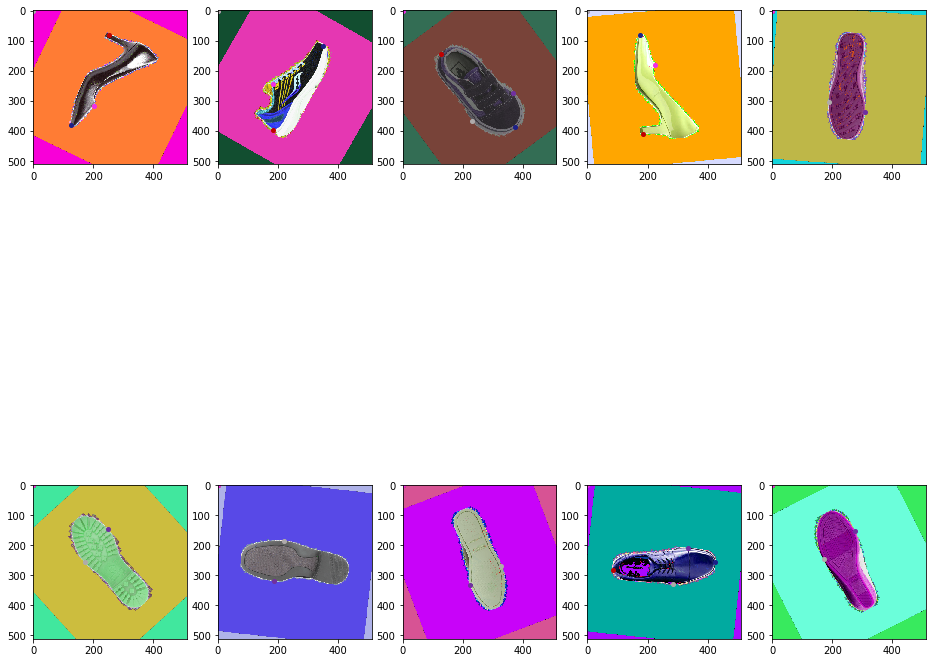

In [20]:
### present five img images and corresponding ground truths in the _train Dataset

plt.figure(figsize=(16, 16))
for i in range(8):
    # special cases:16
    img, lab = _train.__getitem__(300+i)  # 0019, 0031, 0074, 0034, 0091
    plt.subplot(2, 4, i+1)
    plt.imshow(img.transpose(1, 2, 0)) # C, H, W → H, W, C
    # plt.plot(0.5*image_size, 0.5*image_size,'y.')
    # visualize the keypoints
    plt.plot(lab[0]*image_size, lab[1]*image_size,'.', color='#1D2088', markersize = 8) # blue
    plt.plot(lab[2]*image_size, lab[3]*image_size,'.', color='#C00000', markersize = 8) # red
    plt.plot(lab[4]*image_size, lab[5]*image_size,'.', color='#7030A0', markersize = 8) # purple
    plt.plot(lab[6]*image_size, lab[7]*image_size,'.', color='#AFABAB', markersize = 8) # grey
    plt.plot(lab[8]*image_size, lab[9]*image_size,'.', color='#F22CE9', markersize = 8) # magenta

    # plt.axis("off")
    print(lab)

[0.66593707 0.84587586 0.13890287 0.5485036  0.         0.
 0.         0.         0.56186676 0.19840416 1.         1.
 0.         0.         1.        ]
[0.25618166 0.24400696 0.81980246 0.6538141  0.         0.
 0.         0.         0.43680596 0.5722716  1.         1.
 0.         0.         1.        ]
[0.79686135 0.33648452 0.200132   0.6203439  0.         0.
 0.         0.         0.56429374 0.6212275  1.         1.
 0.         0.         1.        ]
[0.7139218  0.76493746 0.23978236 0.28109232 0.513088   0.6910002
 0.65676594 0.4746655  0.         0.         1.         1.
 1.         1.         0.        ]
[0.3329489  0.22020514 0.7159132  0.7585888  0.         0.
 0.         0.         0.4441662  0.64097446 1.         1.
 0.         0.         1.        ]
[0.7670121  0.714315   0.2574301  0.25715083 0.6939569  0.5123236
 0.48869136 0.6525893  0.         0.         1.         1.
 1.         1.         0.        ]
[0.8348293  0.5744128  0.20788644 0.40809146 0.6568011  0.6437342
 0

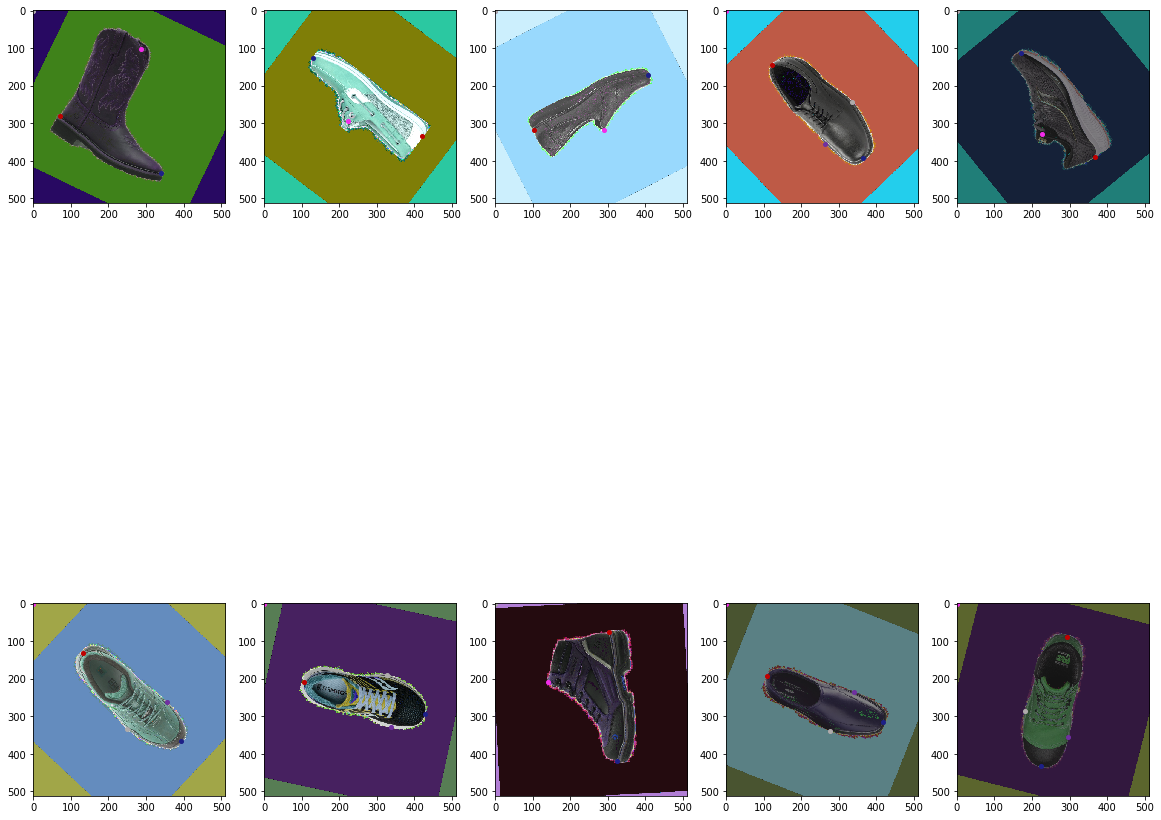

In [ ]:
### present five img images and corresponding ground truths in the _val Dataset

plt.figure(figsize=(20, 20))
for i in range(10):
    img, lab = _val.__getitem__(58+i) # 0084, 0054, 0071, 0046, 0045
    plt.subplot(2, 5, i+1)
    plt.imshow(img.transpose(1, 2, 0))
    # plt.plot(0.5*image_size, 0.5*image_size,'y.')
    # visualize the keypoints
    plt.plot(lab[0]*image_size, lab[1]*image_size,'.', color='#1D2088', markersize = 8) # blue
    plt.plot(lab[2]*image_size, lab[3]*image_size,'.', color='#C00000', markersize = 8) # red
    plt.plot(lab[4]*image_size, lab[5]*image_size,'.', color='#7030A0', markersize = 8) # purple
    plt.plot(lab[6]*image_size, lab[7]*image_size,'.', color='#AFABAB', markersize = 8) # grey
    plt.plot(lab[8]*image_size, lab[9]*image_size,'.', color='#F22CE9', markersize = 8) # magenta
    # plt.axis("off")
    print(lab)
    # print(img.shape)

[0.4707226  0.92028654 0.42088872 0.05857558 0.         0.
 0.         0.         0.6877076  0.4115656  1.         1.
 0.         0.         1.        ]
[0.         0.         0.         0.         0.46754694 0.78523755
 0.7764759  0.53210175 0.         0.         0.         0.
 1.         1.         0.        ]
[0.12377468 0.0931476  0.77102387 0.8801651  0.43145257 0.23103982
 0.20163219 0.57248724 0.         0.         1.         1.
 1.         1.         0.        ]
[0.49664053 0.9094604  0.32659367 0.07063166 0.         0.
 0.         0.         0.7755589  0.33296007 1.         1.
 0.         0.         1.        ]
[0.87194365 0.12942995 0.34824863 0.8033654  0.         0.
 0.         0.         0.22462225 0.3097184  1.         1.
 0.         0.         1.        ]
[0.5371624  0.9400552  0.4587827  0.07892317 0.         0.
 0.         0.         0.6928769  0.38303652 1.         1.
 0.         0.         1.        ]
[0.         0.         0.         0.         0.22107099 0.59235716

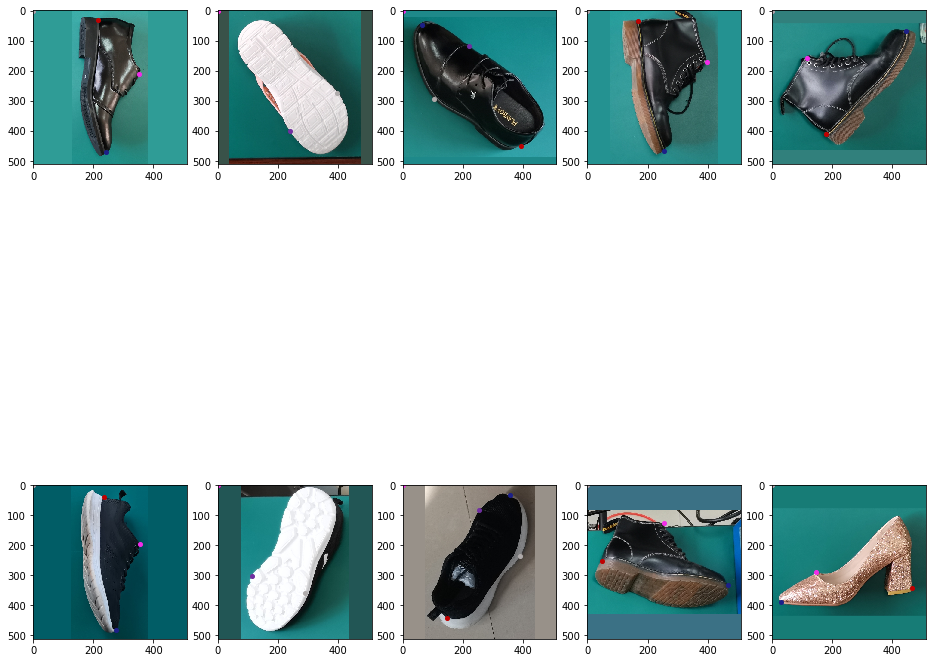

In [25]:
plt.figure(figsize=(16, 16))
for i in range(10):
    # special cases:16
    img, lab = _test.__getitem__(88+i)  # 0019, 0031, 0074, 0034, 0091
    plt.subplot(2, 5, i+1)
    plt.imshow(img.transpose(1, 2, 0)) # C, H, W → H, W, C
    # plt.plot(0.5*image_size, 0.5*image_size,'y.')
    # visualize the keypoints
    plt.plot(lab[0]*image_size, lab[1]*image_size,'.', color='#1D2088', markersize = 8) # blue
    plt.plot(lab[2]*image_size, lab[3]*image_size,'.', color='#C00000', markersize = 8) # red
    plt.plot(lab[4]*image_size, lab[5]*image_size,'.', color='#7030A0', markersize = 8) # purple
    plt.plot(lab[6]*image_size, lab[7]*image_size,'.', color='#AFABAB', markersize = 8) # grey
    plt.plot(lab[8]*image_size, lab[9]*image_size,'.', color='#F22CE9', markersize = 8) # magenta

    # plt.axis("off")
    print(lab)

In [38]:
print(lab)
print((lab[10:]==1))
print(np.where(lab[10:]==1))
print(type(np.where(lab[10:]==1)))
for i in range(len(lab[10:])): 
    if lab[10+i] == 1.0:
        print(i)

[0.05820372 0.75708026 0.9067531  0.6707139  0.         0.
 0.         0.         0.2849154  0.56779397 1.         1.
 0.         0.         1.        ]
[ True  True False False  True]
(array([0, 1, 4]),)
<class 'tuple'>
0
1
4


## Network  
This baseline used ResNet50 to extract the feature from img images.
The detailed introduction of ResNet50 can be found at https://arxiv.org/pdf/1512.03385.pdf .  

The code of ResNet50 in PaddlePaddle framework can be found at https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/models/resnet50_cn.html#resnet50 .

In [5]:
class Network_resnet34(paddle.nn.Layer):
    def __init__(self):
        super(Network_resnet34, self).__init__()
        self.resnet = resnet34(pretrained=True, num_classes=0) # remove final fc 输出为[?, 1024, 1, 1]
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(1024, 512)   
        self.linear_2 = paddle.nn.Linear(512, 256)
        self.linear_3 = paddle.nn.Linear(256, 10)
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
    
    def forward(self, inputs):
        # print('input', inputs)
        y = self.resnet(inputs)
        y = self.flatten(y)
        y = self.linear_1(y)
        y = self.linear_2(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear_3(y)
        y = paddle.nn.functional.sigmoid(y)

        return y

In [6]:
class Network_resnet50(paddle.nn.Layer):
    def __init__(self):
        super(Network_resnet50, self).__init__()
        self.resnet = resnet50(pretrained=True, num_classes=0) # remove final fc 输出为[?, 2048, 1, 1]
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(2048, 512)
        self.linear_2 = paddle.nn.Linear(512, 256)
        self.linear_3 = paddle.nn.Linear(256, 10)
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
    
    def forward(self, inputs):
        # print('input', inputs)
        y = self.resnet(inputs)
        y = self.flatten(y)
        y = self.linear_1(y)
        y = self.linear_2(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear_3(y)
        y = paddle.nn.functional.sigmoid(y)

        return y

In [5]:
class Network_resnet101(paddle.nn.Layer):
    def __init__(self):
        super(Network_resnet101, self).__init__()
        self.resnet = resnet101(pretrained=True, num_classes=0) # remove final fc 输出为[?, 2048, 1, 1]
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(2048, 512)
        self.linear_2 = paddle.nn.Linear(512, 256)
        self.linear_3 = paddle.nn.Linear(256, 10)
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
    
    def forward(self, inputs):
        # print('input', inputs)
        y = self.resnet(inputs)
        y = self.flatten(y)
        y = self.linear_1(y)
        y = self.linear_2(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear_3(y)
        y = paddle.nn.functional.sigmoid(y)

        return y

In [6]:
class Network_resnet101v2(paddle.nn.Layer):
    def __init__(self):
        super(Network_resnet101v2, self).__init__()
        self.resnet = resnet101(pretrained=True, num_classes=0) # remove final fc 输出为[?, 2048, 1, 1]
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(2048, 512)
        self.linear_2 = paddle.nn.Linear(512, 256)
        self.linear_3 = paddle.nn.Linear(256, 10)
        # self.relu = paddle.nn.ReLU()
        # self.dropout = paddle.nn.Dropout(0.2)
    
    def forward(self, inputs):
        # print('input', inputs)
        y = self.resnet(inputs)
        y = self.flatten(y)
        y = self.linear_1(y)
        y = self.linear_2(y)
        # y = self.relu(y)
        # y = self.dropout(y)
        y = self.linear_3(y)
        # y = paddle.nn.functional.sigmoid(y)

        return y

In [7]:
class Network_Scoredresnet101v2(paddle.nn.Layer):
    def __init__(self):
        super(Network_Scoredresnet101v2, self).__init__()
        self.resnet = resnet101(pretrained=True, num_classes=0) # remove final fc 输出为[?, 2048, 1, 1]
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(2048, 512)
        self.linear_2 = paddle.nn.Linear(512, 256)
        self.linear_3 = paddle.nn.Linear(256, 15)
        # self.relu = paddle.nn.ReLU()
        # self.dropout = paddle.nn.Dropout(0.2)
    
    def forward(self, inputs):
        # print('input', inputs)
        y = self.resnet(inputs)
        y = self.flatten(y)
        y = self.linear_1(y)
        y = self.linear_2(y)
        # y = self.relu(y)
        # y = self.dropout(y)
        y = self.linear_3(y)
        # y = paddle.nn.functional.sigmoid(y)

        return y

In [8]:
class Network_resnet152(paddle.nn.Layer):
    def __init__(self):
        super(Network_resnet152, self).__init__()
        self.resnet =  resnet152(pretrained=True, num_classes=0) # remove final fc 输出为[?, 2048, 1, 1]
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(2048, 512)
        self.linear_2 = paddle.nn.Linear(512, 256)
        self.linear_3 = paddle.nn.Linear(256, 10)
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
    
    def forward(self, inputs):
        # print('input', inputs)
        y = self.resnet(inputs)
        y = self.flatten(y)
        y = self.linear_1(y)
        y = self.linear_2(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear_3(y)
        y = paddle.nn.functional.sigmoid(y)

        return y

## Utils

In [7]:
# For coordinates without confidence
# compute ED and loss of multiple points
# cal_ed computes the average ED of a batch when training
def cal_ed(logit, label):
    ed_loss = []
    for i in range(logit.shape[0]):
        for j in range(logit.shape[1]//2):  # logit.shape[1]==5 
            logit_tmp = logit[i,2*j:2*j+2] #.numpy()
            label_tmp = label[i,2*j:2*j+2] #.numpy()
            # print('cal_loss_ed', logit_tmp, label_tmp)        
            ed_tmp = euclidean_distances([logit_tmp], [label_tmp])
            # print('ed_tmp:', ed_tmp[0][0])
            ed_loss.append(ed_tmp)
    
    ed_l = sum(ed_loss)/len(ed_loss)
    return ed_l

# cal_ed_val computes the average ED of a batch when validation
def cal_ed_val(logit, label):
    ed_loss = []
    for i in range(logit.shape[0]):
        for j in range(logit.shape[1]//2):  # logit.shape[1]==5 
            logit_tmp = logit[i,2*j:2*j+2] #.numpy()
            label_tmp = label[i,2*j:2*j+2] #.numpy()
            # print('cal_loss_ed', logit_tmp, label_tmp)        
            ed_tmp = euclidean_distances([logit_tmp], [label_tmp])
            # print('ed_tmp:', ed_tmp[0][0])
            ed_loss.append(ed_tmp)
    
    ed_l = sum(ed_loss)/len(ed_loss)
    
    return ed_l

# loss = alpha*MSE Loss + (1-alpha) *ED
def cal_loss(logit, label, alpha = 0.5):  # alpha =0.4
    """
    logit: shape [batch, ndim]
    label: shape [batch, ndim]
    ndim = 2 represents coordinate_x and coordinaate_y
    alpha: weight for MSELoss and 1-alpha for ED loss
    return: combine MSELoss and ED Loss for x and y, shape [batch, 1]
    """
    alpha = alpha
    mse_loss = nn.MSELoss(reduction='mean')

    mse_coordinates = []
    for i in range(logit.shape[1]):  # logit.shape[1]==10
        mse_coordinates.append(mse_loss(logit[:,i],label[:,i]))
    mse_l = sum(mse_coordinates)/len(mse_coordinates)
    # mse_x = mse_loss(logit[:,0],label[:,0])
    # mse_y = mse_loss(logit[:,1],label[:,1])
    # mse_l = 0.5*(mse_x + mse_y)
    # print('mse_l', mse_l)

    ed_loss = []
    # print(logit.shape[0])
    for i in range(logit.shape[0]):
        for j in range(logit.shape[1]//2):  # logit.shape[1]==5 
            logit_tmp = logit[i,2*j:2*j+2] #.numpy()
            label_tmp = label[i,2*j:2*j+2] #.numpy()
            # print('cal_loss_ed', logit_tmp, label_tmp)        
            ed_tmp = euclidean_distances([logit_tmp], [label_tmp])
            # print('ed_tmp:', ed_tmp[0][0])
            ed_loss.append(ed_tmp)
    ed_l = sum(ed_loss)/len(ed_loss)

    # print('ed_l', ed_l)
    # print('alpha', alpha)
    loss = alpha * mse_l + (1-alpha) * ed_l
    # print('loss in function', loss)
    return loss

In [15]:
# For coordinates with confidence
# compute ED and loss of multiple points
# cal_ed computes the average ED of a batch when training
def cal_ed(logit, label):
    ed_loss = []
    for i in range(logit.shape[0]):  # batchsize
        for j in range(logit.shape[1]//3):
            if label[i,2*logit.shape[1]//3+j] == 1.0:  # confidence == 1
                logit_tmp = logit[i,2*j:2*j+2] #.numpy()
                label_tmp = label[i,2*j:2*j+2] #.numpy()
                ed_tmp = euclidean_distances([logit_tmp], [label_tmp])
                ed_loss.append(ed_tmp)
    
    ed_l = sum(ed_loss)/len(ed_loss)
    return ed_l

# cal_ed_val computes the average ED of a batch when validation
def cal_ed_val(logit, label):
    ed_loss = []
    for i in range(logit.shape[0]):  # batchsize
        for j in range(logit.shape[1]//3):
            if label[i,2*logit.shape[1]//3+j] == 1.0:  # confidence == 1
                logit_tmp = logit[i,2*j:2*j+2] #.numpy()
                label_tmp = label[i,2*j:2*j+2] #.numpy()
                ed_tmp = euclidean_distances([logit_tmp], [label_tmp])
                ed_loss.append(ed_tmp)
    
    ed_l = sum(ed_loss)/len(ed_loss)
    return ed_l

# loss = alpha*MSE Loss + (1-alpha) *ED
def cal_loss(logit, label, alpha = 0.5):  # alpha =0.4
    """
    logit: shape [batch, ndim]
    label: shape [batch, ndim]
    ndim = 2 represents coordinate_x and coordinaate_y
    alpha: weight for MSELoss and 1-alpha for ED loss
    return: combine MSELoss and ED Loss for x and y, shape [batch, 1]
    """
    alpha = alpha
    mse_loss = nn.MSELoss(reduction='mean')

    # confidence loss
    mse_confidence = []
    for j in range(logit.shape[1]//3):  # 10,11,12,13,14  logit.shape[1] 
        mse_confidence.append(mse_loss(logit[:,10+j],label[:,10+j]))
    mse_conf = sum(mse_confidence)/len(mse_confidence)

    # coordinates loss
    mse_coordinates = []
    ed_loss = []
    for i in range(logit.shape[0]):  # batchsize
        for j in range(logit.shape[1]//3):  
            if label[i,2*logit.shape[1]//3+j] == 1.0:  # confidence == 1
                mse_coordinates.append(mse_loss(logit[i,2*j],  label[i,2*j]))
                mse_coordinates.append(mse_loss(logit[i,2*j+1],label[i,2*j+1]))  # mse coordinates loss

                logit_tmp = logit[i,2*j:2*j+2] #.numpy()
                label_tmp = label[i,2*j:2*j+2] #.numpy()
                ed_tmp = euclidean_distances([logit_tmp], [label_tmp])   # coodinates euclidean_distances
                ed_loss.append(ed_tmp)
    
    mse_l = sum(mse_coordinates)/len(mse_coordinates)
    ed_l = sum(ed_loss)/len(ed_loss)

    
    # for i in range(logit.shape[1]):  # logit.shape[1]==10
    #     mse_coordinates.append(mse_loss(logit[:,i],label[:,i]))
    # mse_l = sum(mse_coordinates)/len(mse_coordinates)


    
    # # print(logit.shape[0])
    # for i in range(logit.shape[0]):
    #     for j in range(logit.shape[1]//2):  # logit.shape[1]==5 
    #         logit_tmp = logit[i,2*j:2*j+2] #.numpy()
    #         label_tmp = label[i,2*j:2*j+2] #.numpy()
    #         # print('cal_loss_ed', logit_tmp, label_tmp)        
    #         ed_tmp = euclidean_distances([logit_tmp], [label_tmp])
    #         # print('ed_tmp:', ed_tmp[0][0])
    #         ed_loss.append(ed_tmp)
    # ed_l = sum(ed_loss)/len(ed_loss)

    
    # loss = alpha * mse_l + (1-alpha) * ed_l
    loss = alpha * mse_conf + (1-alpha)/2 * mse_l + (1-alpha)/2 * ed_l  # overall loss
    # print('ed_l', ed_l)
    # print('mse_l', mse_l)
    # print('mse_conf', mse_conf)
    # print('loss in function', loss)
    return loss

In [ ]:
# compute ED and loss of a single point


In [16]:
### Training function
from visualdl import LogWriter
import datetime

def train(model, iters, train_dataloader, val_dataloader, optimizer, log_interval, evl_interval, networkname):
    iter = 0
    model.train()
    avg_loss_list = []
    avg_ED_list = []
    best_ED = sys.float_info.max

    dt = datetime.datetime.now().strftime('%y%m%d_%H%M')            # 
    net_desc = networkname+'_'+dt
    save_folder = os.path.join('trained_models', net_desc)
    logfolder = os.path.join(save_folder,'logs') 
    with LogWriter(logdir=logfolder) as writer: 
        while iter < iters:
            for img, lab in train_dataloader:
                iter += 1
                if iter > iters:
                    break
                imgs = (img / 255.).astype('float32')
                label = lab.astype("float32")

                logits = model(imgs)
                loss = cal_loss(logits, label)
                # print('loss in train',loss)

                for p,l in zip(logits.numpy(), label.numpy()):
                    avg_ED_list.append([p,l])
                
                # print('avg_ED_list', avg_ED_list)
                loss.backward()
                optimizer.step()
                model.clear_gradients()
                avg_loss_list.append(loss.numpy()[0])
                
                if iter % log_interval == 0:
                    avg_loss = np.array(avg_loss_list).mean()
                    # print(avg_loss)
                    avg_ED_list = np.array(avg_ED_list)
                    avg_ED = cal_ed_val(avg_ED_list[:, 0], avg_ED_list[:, 1]) # cal_ED
                    # print('ed in training', avg_ED)
                    avg_loss_list = []
                    avg_ED_list = []
                    
                    # logging.warning("[TRAIN] iter={}/{} avg_loss={:.5f} avg_ED={:.5f}".format(iter, iters, avg_loss, avg_ED[0][0]))
                    print("[TRAIN] iter={}/{} avg_loss={:.4f} avg_ED={:.4f}".format(iter, iters, avg_loss, avg_ED[0][0]))
                    writer.add_scalar(tag="train/avg_ED", step=iter, value=avg_ED[0][0])  # visualiztion
                    writer.add_scalar(tag="train/avg_loss", step=iter, value=avg_loss)  # visualiztion

                if iter % evl_interval == 0:
                    avg_loss, avg_ED = val(model, val_dataloader)
                    print("[EVAL] iter={}/{} avg_loss={:.4f} ED={:.4f}".format(iter, iters, avg_loss, avg_ED[0][0]))
                    writer.add_scalar(tag="eval/avg_ED", step=iter, value=avg_ED[0][0])  # visualiztion
                    writer.add_scalar(tag="eval/avg_loss", step=iter, value=avg_loss)  # visualiztion
                    if avg_ED <= best_ED : # metric is average ED
                    # if avg_ED <= 0.025 and avg_ED <= best_ED:         # change the saving condition to...
                        best_ED = avg_ED[0][0]
                        paddle.save(model.state_dict(),
                                os.path.join(save_folder,"best_model_{:.4f}".format(best_ED), 'model.pdparams'))
                        # paddle.save(optimizer.state_dict(), 
                                # os.path.join('trained_models',"best_model_{:.4f}".format(best_ED), 'optimizer.pdopt'))
                    model.train()

### validation function

def val(model, val_dataloader):
    model.eval()
    avg_loss_list = []
    cache = []
    with paddle.no_grad():
        for data in val_dataloader:
            imgs = (data[0] / 255.).astype("float32")
            labels = data[1].astype('float32')
            
            logits = model(imgs)
            for p, l in zip(logits.numpy(), labels.numpy()):
                cache.append([p, l])

            loss = cal_loss(logits, labels)
            avg_loss_list.append(loss.numpy()[0])

    cache = np.array(cache)
    ED = cal_ed_val(cache[:, 0], cache[:, 1])
    avg_loss = np.array(avg_loss_list).mean()

    return avg_loss, ED

## Training the 1st Network

In [17]:
### generate training Dataset, Dataloader and validation Dataset, Dataloder for the 1st Network

# generate a _train and a _val Dataset for presenting images in the training dataset
img_train_transforms = trans.ComposeWithPoint([         
    trans.PaddedSquareWithPoints('constant'),  # may use 'edge' mode when testing in real scenes. 

    trans.RandomPadWithPoints(pad_thresh_l=0.416, pad_thresh_h=0.512),  # pad_rate should be larger than (√2-1) (0.414)
    trans.RandomHVFlipWithPoints(),
    trans.BackgroundReplacementWithPoints(),
    trans.RandomRotationWithPoints(180),
    trans.BackgroundReplacementWithPoints(),
    trans.ColorJitterWithPoints(0.3, 0.3, 0.3, 0.3)  # (brightness, contrast, saturation, hue)
])

img_test_transforms = trans.ComposeWithPoint([
    trans.PaddedSquareWithPoints('constant'),  # may use 'edge' mode when testing in real scenes. 

    trans.RandomPadWithPoints(pad_thresh_l=0.316, pad_thresh_h=0.412)  # accroding to CropbyBBxinDarknet
])

train_dataset = imgDataset(image_file = train_val_filelists,  # use all web 367 images for training 
                    #    pred_xy=pred_xy,
                       img_transforms = img_train_transforms,
                       label_file=label_file)

val_dataset = imgDataset(image_file = test_filelists,  # images collected from real scenes
                        # pred_xy=pred_xy,
                       img_transforms = img_test_transforms,
                       label_file=label_file)

# generate a _train and a _val Dataset for presenting images in the training dataset

### Load the samples

train_loader = paddle.io.DataLoader(
    train_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(train_dataset, batch_size=batchsize, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(val_dataset, batch_size=batchsize, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

/home/aistudio/transforms.py:1041: UserWarning: Saturation jitter enabled. Will slow down loading immensely.
  'Saturation jitter enabled. Will slow down loading immensely.')
/home/aistudio/transforms.py:1044: UserWarning: Hue jitter enabled. Will slow down loading immensely.
  'Hue jitter enabled. Will slow down loading immensely.')


[0.         0.         0.         0.         0.6612171  0.59049433
 0.4214619  0.597357   0.         0.         0.         0.
 1.         1.         0.        ]
[0.         0.         0.         0.         0.46645212 0.34405294
 0.63505167 0.5136846  0.         0.         0.         0.
 1.         1.         0.        ]
[0.         0.         0.         0.         0.5244724  0.70875454
 0.31595623 0.51242614 0.         0.         0.         0.
 1.         1.         0.        ]
[0.808623   0.6653217  0.21315004 0.31940794 0.7104637  0.46359608
 0.5029589  0.66566455 0.         0.         1.         1.
 1.         1.         0.        ]
[0.4042526  0.17120397 0.8211037  0.6601263  0.         0.
 0.         0.         0.42226303 0.34791178 1.         1.
 0.         0.         1.        ]
[0.83917016 0.5769495  0.19118057 0.44657308 0.6283848  0.6299973
 0.61414164 0.41813368 0.         0.         1.         1.
 1.         1.         0.        ]
[0.5946235  0.22010852 0.47604418 0.8505495

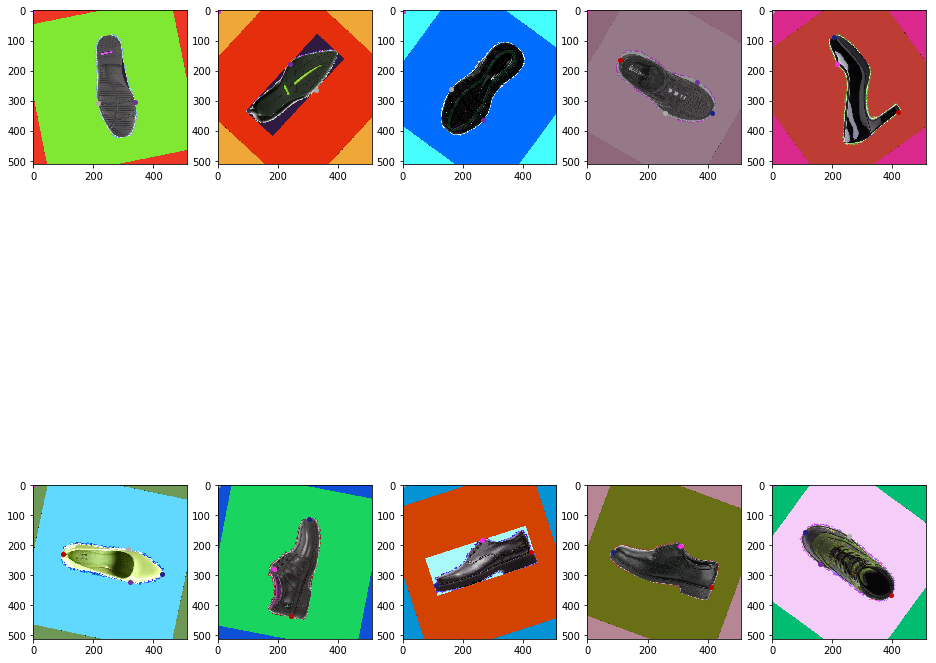

In [18]:
### present five img images and corresponding ground truths in the train Dataset
plt.figure(figsize=(16, 16))
for i in range(10):
    # special cases:16
    img, lab = train_dataset.__getitem__(266+i)  # 0019, 0031, 0074, 0034, 0091
    plt.subplot(2, 5, i+1)
    plt.imshow(img.transpose(1, 2, 0)) # C, H, W → H, W, C
    # plt.plot(0.5*image_size, 0.5*image_size,'y.')
    # visualize the keypoints
    plt.plot(lab[0]*image_size, lab[1]*image_size,'.', color='#1D2088', markersize = 8) # blue
    plt.plot(lab[2]*image_size, lab[3]*image_size,'.', color='#C00000', markersize = 8) # red
    plt.plot(lab[4]*image_size, lab[5]*image_size,'.', color='#7030A0', markersize = 8) # purple
    plt.plot(lab[6]*image_size, lab[7]*image_size,'.', color='#AFABAB', markersize = 8) # grey
    plt.plot(lab[8]*image_size, lab[9]*image_size,'.', color='#F22CE9', markersize = 8) # magenta

    # plt.axis("off")
    print(lab)


[0.777801   0.29195625 0.18587248 0.63309705 0.5895654  0.27284312
 0.6729682  0.56533223 0.         0.         1.         1.
 1.         1.         0.        ]
[0.14360732 0.4225137  0.79495585 0.5413441  0.30188355 0.59360975
 0.325551   0.3352399  0.         0.         1.         1.
 1.         1.         0.        ]
[0.         0.         0.         0.         0.63610464 0.61685556
 0.6463669  0.36420813 0.         0.         0.         0.
 1.         1.         0.        ]
[0.29229945 0.1885534  0.5528557  0.791555   0.29825503 0.39029837
 0.56625575 0.3374427  0.         0.         1.         1.
 1.         1.         0.        ]
[0.56978655 0.8298929  0.42904058 0.16525921 0.         0.
 0.         0.         0.4220033  0.45926186 1.         1.
 0.         0.         1.        ]
[0.         0.         0.         0.         0.64227295 0.32744387
 0.37686136 0.3042975  0.         0.         0.         0.
 1.         1.         0.        ]
[0.         0.         0.         0.      

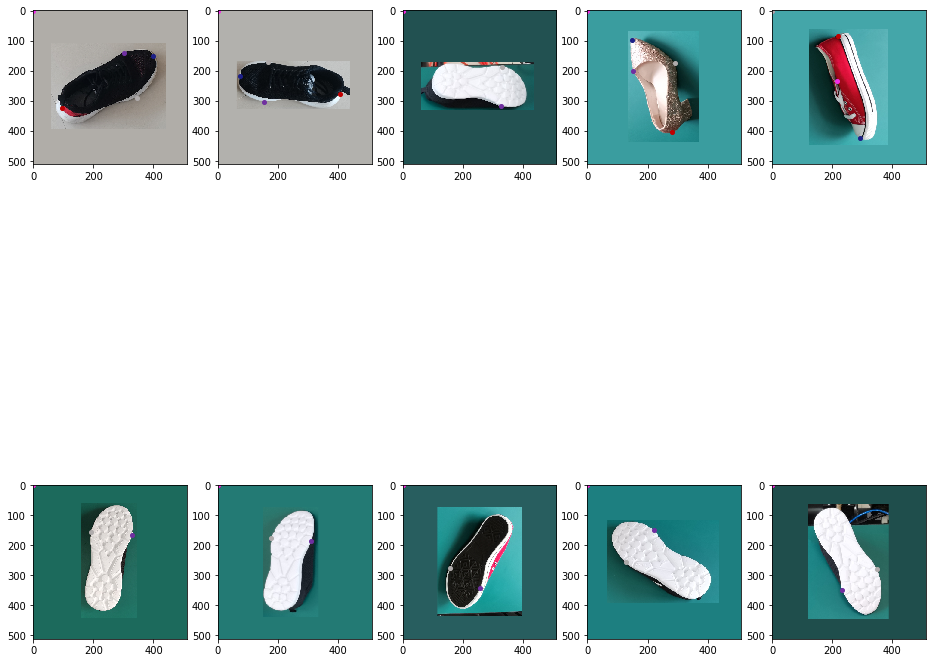

In [19]:
### present five img images and corresponding ground truths in the val Dataset
plt.figure(figsize=(16, 16))
for i in range(10):
    # special cases:16
    img, lab = val_dataset.__getitem__(18+i)  # 0019, 0031, 0074, 0034, 0091
    plt.subplot(2, 5, i+1)
    plt.imshow(img.transpose(1, 2, 0)) # C, H, W → H, W, C
    # plt.plot(0.5*image_size, 0.5*image_size,'y.')
    # visualize the keypoints
    plt.plot(lab[0]*image_size, lab[1]*image_size,'.', color='#1D2088', markersize = 8) # blue
    plt.plot(lab[2]*image_size, lab[3]*image_size,'.', color='#C00000', markersize = 8) # red
    plt.plot(lab[4]*image_size, lab[5]*image_size,'.', color='#7030A0', markersize = 8) # purple
    plt.plot(lab[6]*image_size, lab[7]*image_size,'.', color='#AFABAB', markersize = 8) # grey
    plt.plot(lab[8]*image_size, lab[9]*image_size,'.', color='#F22CE9', markersize = 8) # magenta

    # plt.axis("off")
    print(lab)


In [56]:
### Training the 1st Network 
### Model code was used to generate Model instance, and Optimizer were defined for subsequent training.

# model = Network()  #resnet50
# model = Network_resnet101()
# model = Network_resnet101v2() # resnet101 without ReLU, dropout, sigmoid
model =Network_Scoredresnet101v2()

model_info=paddle.summary(model,(1,3,512,512))  # (1,3,512,512) when image_size = 512
print(model_info)

init_lr = 1e-2
if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(init_lr, parameters=model.parameters())
print(init_lr)

# criterion = cal_loss()

### training process
import warnings
# ignore warnings "Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-no"
# refer to https://blog.csdn.net/time_forgotten/article/details/104792200

# warnings.filterwarnings("ignore")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train(model, iters, train_loader, val_loader, optimizer, log_interval=23, evl_interval=92, networkname = 'Regression_ScoredResnet101v2')

-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
    Conv2D-521       [[1, 3, 512, 512]]   [1, 64, 256, 256]        9,408     
  BatchNorm2D-521   [[1, 64, 256, 256]]   [1, 64, 256, 256]         256      
     ReLU-171       [[1, 64, 256, 256]]   [1, 64, 256, 256]          0       
    MaxPool2D-6     [[1, 64, 256, 256]]   [1, 64, 128, 128]          0       
    Conv2D-523      [[1, 64, 128, 128]]   [1, 64, 128, 128]        4,096     
  BatchNorm2D-523   [[1, 64, 128, 128]]   [1, 64, 128, 128]         256      
     ReLU-172       [[1, 256, 128, 128]]  [1, 256, 128, 128]         0       
    Conv2D-524      [[1, 64, 128, 128]]   [1, 64, 128, 128]       36,864     
  BatchNorm2D-524   [[1, 64, 128, 128]]   [1, 64, 128, 128]         256      
    Conv2D-525      [[1, 64, 128, 128]]   [1, 256, 128, 128]      16,384     
  BatchNorm2D-525   [[1, 256, 128, 128]]  [1, 256, 128, 128]  

Exception in thread Thread-272:
Traceback (most recent call last):
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py", line 583, in _get_data
    data = self._data_queue.get(timeout=self._timeout)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py", line 505, in _thread_loop
    batch = self._get_data()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7

KeyboardInterrupt: 

### Get Predicted Results of the 1st Network  
pred_xy = {1: (x,y), 45:(x,y),... }  

In [ ]:
# Get Predicted Results of the 1st Network
best_model_path = "trained_models/best_model_0.0232/model.pdparams"
model = Network_resnet101()
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)
model.eval()

### gerenate the test Dataset
test1_filelists = images_file
test1_dataset = imgDataset(image_file = test1_filelists, 
                             img_transforms = None ,
                       mode='test') # without Data augmentation when testing

pred_xy={}
# cache=[]
for img, idx, h, w, fh, fw in test1_dataset:   # h,w is the original size of img images
    img = img[np.newaxis, ...]         # h,w is the size of cropped images in 1st Segment Training
    img = paddle.to_tensor((img / 255.).astype("float32"))    
    logits = model(img)
    pred_coor = logits.numpy()
    # print(pred_coor)

    # map to the orignal image cooridinate system
    fx = pred_coor[0][0] * fw  # fx = fx_nor * fw 
    fy = pred_coor[0][1] * fh
    x= fx + (w-fw)/2
    y= fy + (h-fh)/2  
    pred_xy[int(idx[-8:-4])]=(x,y)
    # cache.append([idx[:-10], x, y])
print(len(pred_xy))
# print(pred_xy)

2021-08-30 11:07:03,627 - INFO - unique_endpoints {''}
2021-08-30 11:07:03,628 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams md5 checking...
2021-08-30 11:07:04,498 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet101.pdparams


100


In [ ]:
# visualize the prediction (test)
i='0046'
k='training_data/multi-modality_images/'+ i + '/'+ i+'.jpg'
plt.figure(figsize=(30, 30))
img=cv2.imread(k)[:, :, ::-1]

plt.imshow(img)  
# l= labels[0,:].numpy()
# plt.plot(l[0]*image_size, l[1]*image_size,'r+') 
plt.plot(pred_xy[int(i)][0], pred_xy[int(i)][1],'b+') 

### Training the 2nd Network 

In [ ]:
# imgDataset2 of the 2nd (tiny) network 
class imgDataset2(Dataset):
    def __init__(self,  image_file, pred_xy, label_file=None, img_transforms=None,filelists=None, mode='train'):
        super(imgDataset2, self).__init__()
        self.img_transforms =  img_transforms
        self.mode = mode
        self.image_path = image_file
        # image_idxs = os.listdir(self.image_path)
        image_idxs = self.image_path   # the list of img images' path
        self.label_file = label_file
        self.pred_xy= pred_xy # the predicted absolute coordinates of macular fovea was saved in pred_xy as a dict 
        # self.crop=crop

        if self.mode == 'train':
            label = {int(row['data']): row[1:].values 
                        for _, row in pd.read_excel(label_file).iterrows()}
            self.file_list = [[image_idxs[i], label[int(image_idxs[i][-8:-4])], pred_xy[int(image_idxs[i][-8:-4])]] 
                                for i in range(len(image_idxs))]
            # print(self.file_list)

        elif self.mode == 'test':
            self.file_list = [[image_idxs[i], pred_xy[int(image_idxs[i][-8:-4])], None] for i in range(len(image_idxs))]
        
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item[0] in filelists] 
   
    def __getitem__(self, idx):
        real_index, label, pred_fovea = self.file_list[idx]   # pred_fovea is a tuple
        px, py = int(pred_fovea[0]), int(pred_fovea[1])      # px, py is the absolute coordinate in original image
        img_path = real_index    # real_index = absolute path of img imgs 
        img = cv2.imread(img_path)[:, :, ::-1] # BGR -> RGB        
        h,w,c = img.shape   # h,w,c is the original shape

        # Crop the Region of Interest
        top = py - 63
        left= px - 63
        mh, mw = 128,128
        img= F.crop(img, top, left, mh, mw)

        # Crop ROI of label
        if self.mode == 'train':
            x= float(label[0])
            y= float(label[1])
            
            mx = x - left  # map the label into cropped image(fw, fh) coordiante system
            my = y - top  
            # print("%.f, %.f, %.f, %.f"%(w,fw,x,fx))
            # print("%.f, %.f, %.f, %.f"%(h,fh,y,fy))
            # Normalization
            label_nor = (mx/mw, my/mh)  
            label_nor = np.array(label_nor).astype('float32').reshape(2)  # from tuple to np.array

        # without Resize in tiny network
        # img_re = cv2.resize(img,(image_size, image_size))
        # Data Augmengtation
        if self.img_transforms is not None:
            img, label_nor[0], label_nor[1]= self.img_transforms(img, label_nor[0], label_nor[1])
            
        img = img.transpose(2, 0, 1) # H, W, C -> C, H, W
        # img = img_re.astype(np.float32)
        
        if self.mode == 'test':
            return img, real_index, h, w, top, left
        if self.mode == 'train':
            return img, label_nor

    def __len__(self):
        return len(self.file_list)

In [ ]:
### Data Cleaner 
bad_train_labels = ['0016','0022','0030','0032','0058','0069','0087','0089']
for i in bad_train_labels:
    b= 'training_data/multi-modality_images/'+ i + '/'+ i +'.jpg'
    if b in train_filelists:
        train_filelists.remove(b)
bad_val_labels= 'training_data/multi-modality_images/0084/0084.jpg'
val_filelists.remove(bad_val_labels)
print(len(train_filelists))
# print(train_filelists)
print(val_filelists)

# find out if bad labels are still exist
count =[]
for i in bad_train_labels:
    b= 'training_data/multi-modality_images/'+ i + '/'+ i +'.jpg'
    if b in train_filelists:
        count.append(b)
print(count)

In [ ]:
# generate training Dataset, Dataloader and validation Dataset, Dataloader for the 2nd Network
img_train_transforms = trans.ComposeWithPoint([         
    trans.RandomHorizontalFlipWithPoint(),
    trans.RandomVerticalFlipWithPoint(),
    trans.RandomRotationWithPoint(30),
    trans.ColorJitterWithPoint(0.2, 0.2, 0.2, 0.05)  # 0.4, 0.4, 0.4, 0.1 brightness, contrast, saturation and hue
])

# ComposeWithPoint is defined by Marco
img_val_transforms = trans.ComposeWithPoint([

])

train_dataset = imgDataset2(image_file = train_filelists, 
                              pred_xy=pred_xy ,
                              img_transforms = img_train_transforms,   
                              label_file=label_file,
                       )

val_dataset = imgDataset2(image_file = val_filelists, 
                            pred_xy= pred_xy ,
                            img_transforms = img_val_transforms,
                            label_file=label_file,
                       )
            
### Load the samples

train_loader = paddle.io.DataLoader(
    train_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(train_dataset, batchsize=batchsize, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(val_dataset, batchsize=batchsize, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

/home/aistudio/transforms.py:770: UserWarning: Saturation jitter enabled. Will slow down loading immensely.
  'Saturation jitter enabled. Will slow down loading immensely.')
/home/aistudio/transforms.py:773: UserWarning: Hue jitter enabled. Will slow down loading immensely.
  'Hue jitter enabled. Will slow down loading immensely.')


In [ ]:
# present img images and corresponding ground truths i in 2nd Network Training Period
plt.figure(figsize=(15, 15))
for i in range(10):
    img, lab = train_dataset.__getitem__(11)
    plt.subplot(2, 5, i+1)
    plt.imshow(img.transpose(1, 2, 0))
    plt.plot(lab[0]*128, lab[1]*128,'b+')
    # plt.axis("off")
    print(lab)

In [ ]:
### Training the 2nd Network 
# the results should be less than 0.1856 theoritically
model = Network_resnet101()
# para_state_dict = paddle.load("trained_models/best_model_0.0232/model.pdparams")
model.set_state_dict(para_state_dict)

init_lr = 1e-3
if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(init_lr, parameters=model.parameters())
print(init_lr)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train(model, iters, train_loader, val_loader, optimizer, log_interval=30, evl_interval=180)

## Incremental Training/ Transfer Learning

In [ ]:
### Incremental Training/ Transfer Learning Code
# model = Network_resnet101()
# model = Network_resnet101v2()
model =Network_Scoredresnet101v2()

optimizer_type = 'adam'
if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(1e-3, parameters=model.parameters())
elif optimizer_type == 'sgd':
    optimizer = paddle.optimizer.SGD(learning_rate=1e-3, parameters=model.parameters(), 
                                     weight_decay=None) # , grad_clip=None, name=None
else:
    print("No such optimzier, please add it by yourself")
    
para_state_dict = paddle.load("trained_models/Regression_ScoredResnet101v2_220220_1851/best_model_0.3525/model.pdparams")
# opt_state_dict = paddle.load("trained_models/best_model_0.0195/optimizer.pdopt")

model.set_state_dict(para_state_dict)
# optimizer.set_state_dict(opt_state_dict)

iters = 15000

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train(model, iters, train_loader, val_loader, optimizer, log_interval=23, evl_interval=92, networkname = 'Regression_ScoredResnet101v2')

## Evaluation and Visualiztion

Avg ED = [[0.2513357]]
Tensor(shape=[15], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.47952744, 0.48404574, 0.55620283, 0.51319796, 0.49501735, 0.49234179,
        0.49237302, 0.45056409, 0.48837423, 0.51199687, 0.74796611, 0.75453770,
        0.53538686, 0.52981704, 0.45267516])
Tensor(shape=[15], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.47956526, 0.48407394, 0.55627143, 0.51328468, 0.49503952, 0.49235609,
        0.49241218, 0.45059207, 0.48838025, 0.51194900, 0.74794132, 0.75456452,
        0.53537500, 0.52984834, 0.45266867])
Tensor(shape=[15], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.47956550, 0.48410141, 0.55630136, 0.51321858, 0.49501592, 0.49235159,
        0.49236345, 0.45059091, 0.48838440, 0.51201010, 0.74793255, 0.75455564,
        0.53539771, 0.52979243, 0.45268184])
Tensor(shape=[15], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.47956038, 0.48409522, 0.55628854, 0.51321018, 0.49501407

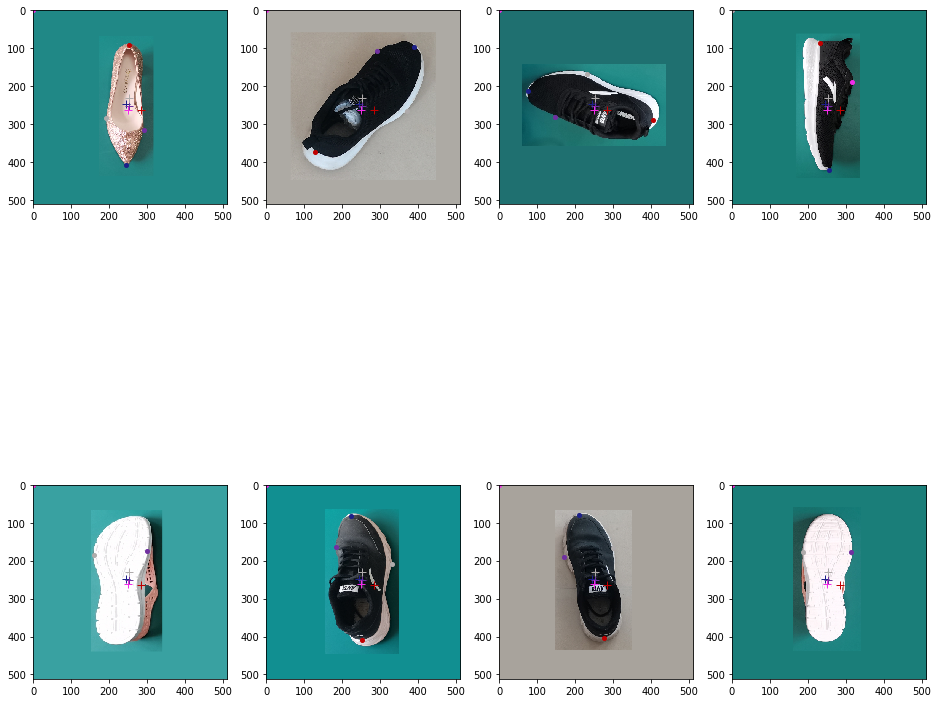

In [22]:
# Outliers (max error points):
def test(model, val_dataloader):
    model.eval()
    avg_loss_list = []
    cache = []  # ?
    with paddle.no_grad():
        for data in val_dataloader:
            imgs = (data[0] / 255.).astype("float32")
            labels = data[1].astype('float32')
            # print(data) # Tensor(shape=[batchsize, C, H, W]
            
            logits = model(imgs)
            # print(logits)  # Tensor(shape=[batchsize, output_dims]
            # Visualiztion
            # print(labels) # Tensor(shape=[batchsize, output_dims]
            
            for p, l in zip(logits.numpy(), labels.numpy()):
                cache.append([p, l])

            loss = cal_loss(logits, labels)
            avg_loss_list.append(loss.numpy()[0])

    cache = np.array(cache)
    ED = cal_ed_val(cache[:, 0], cache[:, 1])
    avg_loss = np.array(avg_loss_list).mean()

    return avg_loss, ED, logits, labels, imgs


img_test_transforms = trans.ComposeWithPoint([
    trans.PaddedSquareWithPoints('constant'),  # may use 'edge' mode when testing in real scenes. 

    trans.RandomPadWithPoints(pad_thresh_l=0.316, pad_thresh_h=0.412)  # accroding to CropbyBBxinDarknet
])

test_dataset = imgDataset(image_file = test_filelists[156:164],  # [test_filelists[8]] images collected from real scenes
                        # pred_xy=pred_xy,
                       img_transforms = img_test_transforms,
                       label_file=label_file)

test_loader = paddle.io.DataLoader(
    test_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(test_dataset, batch_size=8, shuffle=False, drop_last=False),
    # num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)


best_model_path = "trained_models/Regression_ScoredResnet101v2_220220_1943/best_model_0.2580/model.pdparams"

# model= Network_resnet101v2()
model = Network_Scoredresnet101v2()
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)

avg_loss, ED, logits, labels, imgs= test(model,test_loader)  # the size of logits, label is (bacth, output_dims)
print("Avg ED = {}".format(ED))

### visualize predicted results and corresponding ground truths of Testing Images
# the size of logits, label is (bacth, output_dims)
plt.figure(figsize=(16, 16))
for i in range(8):
    # special cases:16
    # img, lab = test_dataset.__getitem__(i)  # 0019, 0031, 0074, 0034, 0091
    img=imgs[i].numpy() # transfer paddle.Tensor to numpy.ndarray
    lab=labels[i]
    pre = logits[i]
    plt.subplot(2, 4, i+1)
    plt.imshow(img.transpose(1,2,0)) # C, H, W → H, W, C
    # plt.plot(0.5*image_size, 0.5*image_size,'y.')
    # visualize the keypoints
    plt.plot(lab[0]*image_size, lab[1]*image_size,'.', color='#1D2088', markersize = 8) # blue
    plt.plot(lab[2]*image_size, lab[3]*image_size,'.', color='#C00000', markersize = 8) # red
    plt.plot(lab[4]*image_size, lab[5]*image_size,'.', color='#7030A0', markersize = 8) # purple
    plt.plot(lab[6]*image_size, lab[7]*image_size,'.', color='#AFABAB', markersize = 8) # grey
    plt.plot(lab[8]*image_size, lab[9]*image_size,'.', color='#F22CE9', markersize = 8) # magenta

    
    plt.plot(pre[0]*image_size, pre[1]*image_size,'+', color='#1D2088', markersize = 8) # blue
    plt.plot(pre[2]*image_size, pre[3]*image_size,'+', color='#C00000', markersize = 8) # red
    plt.plot(pre[4]*image_size, pre[5]*image_size,'+', color='#7030A0', markersize = 8) # purple
    plt.plot(pre[6]*image_size, pre[7]*image_size,'+', color='#AFABAB', markersize = 8) # grey
    plt.plot(pre[8]*image_size, pre[9]*image_size,'+', color='#F22CE9', markersize = 8) # magenta

    # plt.axis("off")
    print(pre)


# Heatmap Method


0.009999990463256836
512 512
0.9999257
(array([287]), array([501]))
147445
x=501, y=287
0.9999257


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

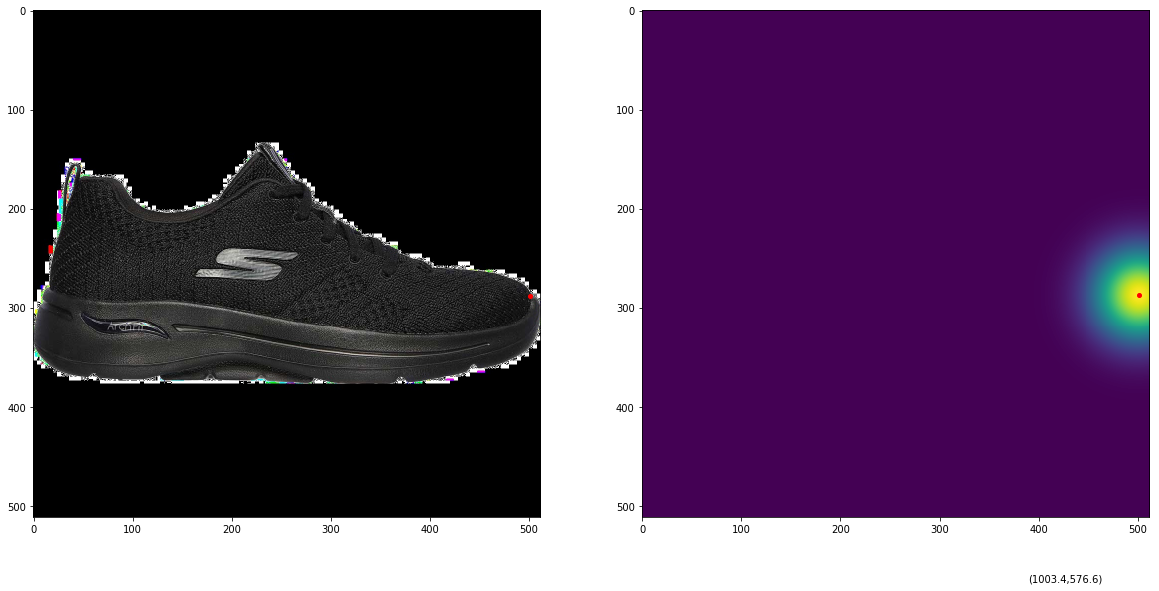

0.0
(array([273, 273, 273, 273, 273, 273, 273, 274, 274, 274, 274, 274, 274,
       274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275, 275, 275,
       275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 276, 276, 276,
       276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276,
       276, 276, 276, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277,
       277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 278, 278,
       278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278,
       278, 278, 278, 278, 278, 278, 278, 279, 279, 279, 279, 279, 279,
       279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279,
       279, 279, 279, 279, 280, 280, 280, 280, 280, 280, 280, 280, 280,
       280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280,
       280, 280, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281,
       281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281,
       282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 28

In [4]:
# sklearn.mixture.GaussianMixture

import time
import numpy as np
import cv2
import matplotlib.pyplot as plt


def CenterLabelHeatMap(img_width, img_height, c_x, c_y, sigma=32):  # faster, sigma controls the size of gaussian kernel
    X1 = np.linspace(1, img_width, img_width)
    Y1 = np.linspace(1, img_height, img_height)
    [X, Y] = np.meshgrid(X1, Y1)
    X = X - c_x
    Y = Y - c_y
    D2 = X * X + Y * Y
    E2 = 2.0 * sigma * sigma
    Exponent = D2 / E2
    heatmap = np.exp(-Exponent).astype('float32')
    return heatmap

# # Method 2: slower
# # Compute gaussian kernel
# def CenterGaussianHeatMap(img_height, img_width, c_x, c_y, variance):
#     gaussian_map = np.zeros((img_height, img_width))
#     for x_p in range(img_width):
#         for y_p in range(img_height):
#             dist_sq = (x_p - c_x) * (x_p - c_x) + \
#                       (y_p - c_y) * (y_p - c_y)
#             exponent = dist_sq / 2.0 / variance / variance
#             gaussian_map[y_p, x_p] = np.exp(-exponent)
#     return gaussian_map


image_file = 'TrainingSet/124403w-bbk-sbgow__2.jpg'
img = cv2.imread(image_file)
img = img[:,:,::-1]
img = cv2.resize(img,(image_size, image_size))

height, width,_ = np.shape(img)
kx, ky = 1003.448275862069/2, 576.551724137931/2   # height/2.0, 

start = time.time()
heatmap1 = CenterLabelHeatMap(width, height, kx, ky, 32) # 
t1 = time.time() - start

# start = time.time()
# heatmap2 = CenterGaussianHeatMap(height, width, kx, ky, 21)
# t2 = time.time() - start

# print(t1, t2)
print(t1)
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(img)
plt.plot(1003.448275862069//2, 576.551724137931//2,'r.', markersize=8)
plt.text(1003.448275862069, 576.551724137931, "(1003.4,576.6)")


# Infer the max value and corresponding location
print(height, width)

print(heatmap1.max())
print(np.where(heatmap1==heatmap1.max()))
print(heatmap1.argmax())
# x = heatmap1.argmax()%width
# y = heatmap1.argmax()//width
x= np.where(heatmap1==heatmap1.max())[1][0]
y= np.where(heatmap1==heatmap1.max())[0][0]
print('x={}, y={}'.format(x,y))
print(heatmap1[y,x])

plt.subplot(1,2,2)
plt.imshow(heatmap1)
plt.plot(x, y,'r.', markersize=8)
# plt.grid(True)
plt.show()

print(heatmap1.min())

thresh = 0.9
print(np.where(heatmap1>=thresh))
print(len(np.where(heatmap1>=thresh)[0]))
print(len(np.where(heatmap1>=thresh)[0])/(512*512))

# print(heatmap1.sum())


In [69]:
heatmap1.max()

0.0

## Dataloader

In [6]:
### Class Dataset of the first network
### load the img images from the data folder, 
### and extract the corresponding ground truth to generate training samples
def CenterLabelHeatMap(img_width, img_height, c_x, c_y, sigma=64):  # faster, sigma controls the size of gaussian kernel
    X1 = np.linspace(1, img_width, img_width)
    Y1 = np.linspace(1, img_height, img_height)
    [X, Y] = np.meshgrid(X1, Y1)
    X = X - c_x
    Y = Y - c_y
    D2 = X * X + Y * Y
    E2 = 2.0 * sigma * sigma
    Exponent = D2 / E2
    heatmap = np.exp(-Exponent).astype('float32')
    return heatmap

class imgDataset(Dataset):
    def __init__(self,  image_file, label_file=None, img_transforms=None,filelists=None,  mode='train', index_mode = False):
        super(imgDataset, self).__init__()
        self.img_transforms =  img_transforms
        self.mode = mode.lower()
        self.image_path = image_file
        # image_idxs = os.listdir(self.image_path)
        image_idxs = self.image_path   # the list of img images' path
        self.label_file = label_file
        self.index_mode = index_mode
        # self.crop=crop

        if self.mode == 'train':
            label = {row['img_name']: row[1:].values 
                        for _, row in pd.read_excel(label_file).iterrows()}
            self.file_list = [[image_idxs[i], label[image_idxs[i].split('/')[-1]]] for i in range(len(image_idxs))] # split('/')[-1][:-4]
            # print(self.file_list)

        elif self.mode == 'test':
            self.file_list = [[image_idxs[i], None] for i in range(len(image_idxs))]
        
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item[0] in filelists] 
   
    def __getitem__(self, idx):
        real_index, label = self.file_list[idx]
        img_path = real_index    # real_index = absolute path of imgs 
        img = cv2.imread(img_path)[:, :, ::-1] # BGR -> RGB        
        h,w,c = img.shape   # h,w,c is the original shape

        fh, fw = h,w   # fh, fw is the shape of original images acquired from object detection.

        if self.mode == 'train':
            confidence= (float(label[0]), float(label[3]), float(label[6]), float(label[9]) , float(label[12]))
            x         = (float(label[1]), float(label[4]), float(label[7]), float(label[10]), float(label[13]))  # 
            y         = (float(label[2]), float(label[5]), float(label[8]), float(label[11]), float(label[14]))
            fx = x
            fy = y

            # Normalization
            label_nor = (tuple(fi/fw for fi in fx), tuple(fj/fh for fj in fy))  
            label_nor = np.array(label_nor).astype('float32').reshape(2,5)  # from tuple to np.array
            confidence= np.array(confidence).astype('float32').reshape(5)
            
            # Data Augmengtation
            if self.img_transforms is not None:
                img_re, label_nor[0], label_nor[1]= self.img_transforms(img, label_nor[0], label_nor[1],confidence)
                img_re = cv2.resize(img_re,(image_size, image_size)) # ignore it when we use RandomResizedCrop
            
            img = img_re.transpose(2, 0, 1) # H, W, C -> C, H, W
            # img = img_re.astype(np.float32)

            label_nor = label_nor.reshape(10, order ='F') # reshape to a 1x10 ndarray [toe_end_x toe_end_y heel...] 
            # label_nor =  np.append(label_nor, confidence)  
            
            c,h,w = img.shape   # h, w is the shape of current images acquired from object detection.

            if confidence[0] == 1.0:
                label_heatmaps = CenterLabelHeatMap(w, h, w*label_nor[2*0], h*label_nor[2*0+1], 32) # heatmap method
            else:
                label_heatmaps = CenterLabelHeatMap(w, h, w*label_nor[2*0], h*label_nor[2*0+1], 0) # heatmap method
            # print(label_heatmaps.shape)
            for j in range(1, len(label_nor)//2):
                if confidence[j] == 1.0:
                    heatmap1 = CenterLabelHeatMap(w, h, w*label_nor[2*j], h*label_nor[2*j+1], 32)
                else:
                    heatmap1 = CenterLabelHeatMap(w, h, w*label_nor[2*j], h*label_nor[2*j+1], 0)
                label_heatmaps = cv2.merge([label_heatmaps, heatmap1])
            label_heatmaps = label_heatmaps.transpose(2, 0, 1) # H, W, C -> C, H, W
            # print(type(label_heatmaps))
            # print(label_heatmaps.shape)
            if self.index_mode == False:
                return img, label_heatmaps # return img, label_nor
            else: # self.index_mode == True
                return img, label_heatmaps, real_index
        
        elif self.mode == 'test':
            # Data Augmengtation
            if self.img_transforms is not None:
                img_re = self.img_transforms(img)
                img_re = cv2.resize(img_re,(image_size, image_size)) # ignore it when we use RandomResizedCrop
            img = img_re.transpose(2, 0, 1) # H, W, C -> C, H, W
            c,h,w = img.shape   # h, w is the shape of current images acquired from object detection.
            return img, real_index, h, w, fh, fw  #  fh, fw is the shape of original images, while h, w is the shape of current images

        else:
            print('No such mode')
            return None

    def __len__(self):
        return len(self.file_list)


In [7]:
### generate training Dataset, Dataloader and validation Dataset, Dataloder for the 1st Network

# generate a _train and a _val Dataset for presenting images in the training dataset
img_train_transforms = trans.ComposeWithPoint([         
    trans.PaddedSquareWithPoints('constant'),  # may use 'edge' mode when testing in real scenes. 

    trans.RandomPadWithPoints(pad_thresh_l=0.416, pad_thresh_h=0.512),  # pad_rate should be larger than (√2-1) (0.414)
    trans.RandomHVFlipWithPoints(),
    trans.BackgroundReplacementWithPoints(),
    trans.RandomRotationWithPoints(180),
    trans.BackgroundReplacementWithPoints(),
    trans.ColorJitterWithPoints(0.2, 0.2, 0.2, 0.2)  # (brightness, contrast, saturation, hue)
])

img_test_transforms = trans.ComposeWithPoint([
    trans.PaddedSquareWithPoints('constant'),  # may use 'edge' mode when testing in real scenes. 

    trans.RandomPadWithPoints(pad_thresh_l=0.384, pad_thresh_h=0.384)  #pad_thresh_l=0.326, pad_thresh_h=0.442 accroding to CropbyBBxinDarknet (1.04)  pad_thresh_l=0.400, pad_thresh_h=0.400
])

train_dataset = imgDataset(image_file = train_val_test_filelists, #train_val_filelists[220:228],train_val_filelists, train_val_test_filelists # use all web 367 images for training 
                    #    pred_xy=pred_xy,
                       img_transforms = img_train_transforms,
                       label_file=label_file)

val_dataset = imgDataset(image_file = test_filelists,  # images collected from real scenes
                        # pred_xy=pred_xy,
                       img_transforms = img_test_transforms,
                       label_file=label_file)

# generate a _train and a _val Dataset for presenting images in the training dataset

### Load the samples

train_loader = paddle.io.DataLoader(
    train_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(train_dataset, batch_size=batchsize, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(val_dataset, batch_size=batchsize, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

/home/aistudio/transforms.py:1100: UserWarning: Saturation jitter enabled. Will slow down loading immensely.
  'Saturation jitter enabled. Will slow down loading immensely.')
/home/aistudio/transforms.py:1103: UserWarning: Hue jitter enabled. Will slow down loading immensely.
  'Hue jitter enabled. Will slow down loading immensely.')


In [8]:
len(train_val_filelists)

367

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reu

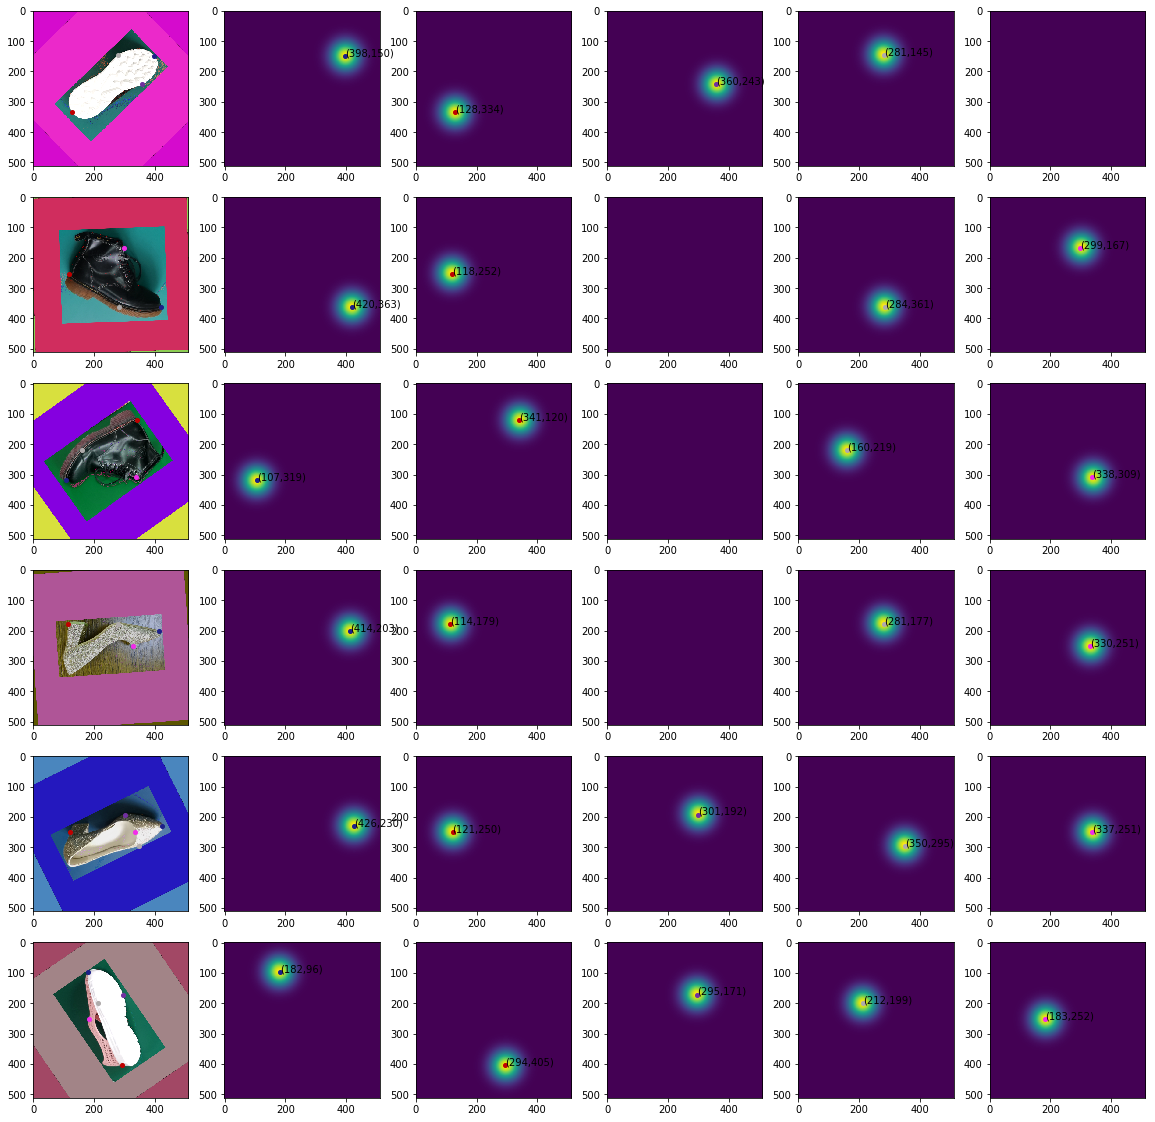

In [8]:
### present original images and corresponding ground-truth heatmaps in the train Dataset
plt.figure(figsize=(20, 20))
colors = ['#1D2088', '#C00000','#7030A0','#AFABAB', '#F22CE9'] # blue, red, purple, grey, magenta
num = 6
for i in range(num):
    # special cases:16
    img, lab = train_dataset.__getitem__(400+i)  # 0019, 0031, 0074, 0034, 0091
    plt.subplot(num, 6, 6*i+1)
    plt.imshow(img.transpose(1, 2, 0)) # C, H, W → H, W, C
    
    # visualize the heatmaps
    for j in range(lab.shape[0]):
        plt.subplot(num,6,6*i+j+2)
        plt.imshow(lab[j])
        if lab[j].max() >= 0.9:
            kx= np.where(lab[j]==lab[j].max())[1][0]
            ky= np.where(lab[j]==lab[j].max())[0][0]
            # print('x={}, y={}'.format(x,y))
            # print(heatmap1[y,x])
            plt.plot(kx, ky,'.', color=colors[j], markersize=8)
            plt.text(kx, ky, "({},{})".format(kx,ky))
            plt.subplot(num, 6, 6*i+1)
            plt.plot(kx, ky,'.', color=colors[j], markersize=8)
        # plt.grid(True)
    # plt.show()

    # plt.axis("off")


In [8]:
len(train_dataset.image_path)

557

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


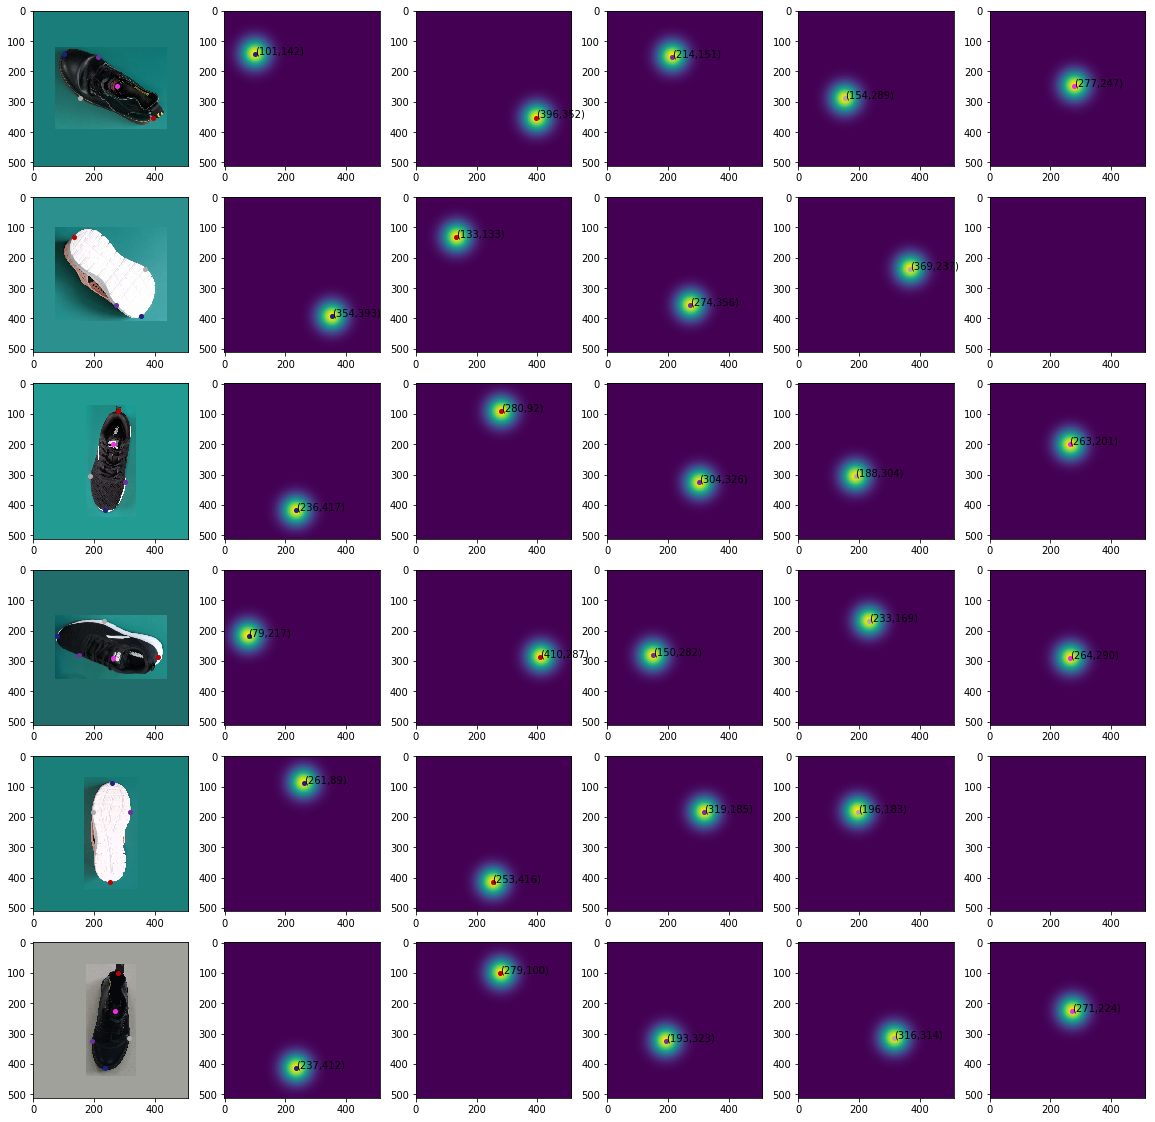

In [9]:
### present  original images and corresponding ground-truth heatmaps in the val Dataset
plt.figure(figsize=(20, 20))
colors = ['#1D2088', '#C00000','#7030A0','#AFABAB', '#F22CE9'] # blue, red, purple, grey, magenta
num = 6
for i in range(num):
    # special cases:16
    img, lab = val_dataset.__getitem__(99+i)  # 0019, 0031, 0074, 0034, 0091
    plt.subplot(num, 6, 6*i+1)
    plt.imshow(img.transpose(1, 2, 0)) # C, H, W → H, W, C
    
    # visualize the heatmaps
    for j in range(lab.shape[0]):
        plt.subplot(num,6,6*i+j+2)
        plt.imshow(lab[j])
        if lab[j].max() >= 0.9:
            kx= np.where(lab[j]==lab[j].max())[1][0]
            ky= np.where(lab[j]==lab[j].max())[0][0]
            # print('x={}, y={}'.format(x,y))
            # print(heatmap1[y,x])
            plt.plot(kx, ky,'.', color=colors[j], markersize=8)
            plt.text(kx, ky, "({},{})".format(kx,ky))
            plt.subplot(num, 6, 6*i+1)
            plt.plot(kx, ky,'.', color=colors[j], markersize=8)
        # plt.grid(True)
    # plt.show()

    # plt.axis("off")

## Networks

In [ ]:
# GR-ConvNet

## Utils

In [18]:
# For coordinates without confidence
# compute ED and loss of multiple points
# cal_ed computes the average ED of a batch when training
def cal_ed(logit, label):
    ed_loss = []
    for i in range(logit.shape[0]):  
        for j in range(logit.shape[1]):  # logit.shape[1]==5
            if label[i][j].max() >= 0.9:
                kx_l= np.where(label[i][j]==label[i][j].max())[1][0]
                ky_l= np.where(label[i][j]==label[i][j].max())[0][0]

                kx_p= np.where(logit[i][j]==logit[i][j].max())[1][0]  # predicted keypoints
                ky_p= np.where(logit[i][j]==logit[i][j].max())[0][0]

                ed_tmp = euclidean_distances([kx_p, ky_p],[kx_l, ky_l])
                ed_loss.append(ed_tmp)

    ed_l = sum(ed_loss)/len(ed_loss) 
    return ed_l

# cal_ed_val computes the average ED of a batch when validation
def cal_ed_val(logit, label):
    ed_loss = []
    h= logit.shape[2]
    w= logit.shape[3]
    # print(h,w)
    for i in range(logit.shape[0]):  
        for j in range(logit.shape[1]):  # logit.shape[1]==5
            if label[i][j].max() >= 0.9:
                kx_l= np.where(label[i][j]==label[i][j].max())[1][0] #+ 0.5 
                ky_l= np.where(label[i][j]==label[i][j].max())[0][0] #+ 0.5

                kx_p= np.where(logit[i][j]==logit[i][j].max())[1][0] #+ 0.5 # predicted keypoints
                ky_p= np.where(logit[i][j]==logit[i][j].max())[0][0] #+ 0.5
                
                # calculate euclidean_distances by normalizad kx, ky
                ed_tmp = euclidean_distances([[kx_p/w, ky_p/h]],[[kx_l/w, ky_l/h]]) # 2D arrays are expected 
                # calculate euclidean_distances by absolute kx, ky
                # ed_tmp = euclidean_distances([[kx_p, ky_p]],[[kx_l, ky_l]])

                ed_loss.append(ed_tmp)
    
    ed_l = sum(ed_loss)/len(ed_loss)
    
    return ed_l

# loss = alpha*MSE Loss + (1-alpha) *ED
def cal_loss(logit, label, alpha = 0.618):  #  0.75 0.618
    """
    logit: shape [batch, ndim]
    label: shape [batch, ndim]
    ndim = 2 represents coordinate_x and coordinaate_y
    alpha: weight for MSELoss and 1-alpha for ED loss
    return: combine MSELoss and ED Loss for x and y, shape [batch, 1]
    """
    h= logit.shape[2]
    w= logit.shape[3]
    # MSE Loss, a.k.a L2 Loss
    mse_loss = nn.MSELoss(reduction='mean')
    # As heatmap values are in (0,1), L1 Loss is more sensitive than L2 Loss, L2 Loss is more sensitive than SmoothL1Loss
    # mse_loss = nn.L1Loss(reduction='mean')

    mse_coordinates = []
    ed_loss = []
    for i in range(logit.shape[0]):  
        for j in range(logit.shape[1]):  # logit.shape[1]==5
            mse_coordinates.append(mse_loss(logit[i][j],label[i][j]))  # MSE loss or L1 Loss for every pixels in the heatmap

            if label[i][j].max() >= 0.9:  # euclidean_distances loss for keypoints
                kx_l= np.where(label[i][j]==label[i][j].max())[1][0] #+ 0.5
                ky_l= np.where(label[i][j]==label[i][j].max())[0][0] #+ 0.5

                kx_p= np.where(logit[i][j]==logit[i][j].max())[1][0] #+ 0.5  # predicted keypoints
                ky_p= np.where(logit[i][j]==logit[i][j].max())[0][0] #+ 0.5
                
                # calculate euclidean_distances by normalizad kx, ky
                # ed_tmp = euclidean_distances([[kx_p/w, ky_p/h]],[[kx_l/w, ky_l/h]]) # 2D arrays are expected 
                _p = paddle.to_tensor([kx_p/w, ky_p/h],stop_gradient=False)
                _l = paddle.to_tensor([kx_l/w, ky_l/h],stop_gradient=False)
                ed_tmp = mse_loss(_p,_l)

                ed_loss.append(ed_tmp)
    mse_l = sum(mse_coordinates)/len(mse_coordinates)
    ed_l = sum(ed_loss)/len(ed_loss)

    loss = alpha * mse_l + (1-alpha) * ed_l
    # print(logit)
    # print(label)
    # print('ed_l', ed_l)
    # print('mse_l', mse_l)
    # print('alpha', alpha)
    # print('loss in function', loss)
    return loss

In [19]:
### Training function
from visualdl import LogWriter
import datetime

# def train(model, iters, train_dataloader, val_dataloader, optimizer, scheduler,  log_interval, evl_interval, networkname):
def train(model, iters, train_dataloader, val_dataloader, optimizer, log_interval, evl_interval, networkname):
    iter = 0
    model.train()
    avg_loss_list = []
    avg_ED_list = []
    best_ED = sys.float_info.max

    dt = datetime.datetime.now().strftime('%y%m%d_%H%M')            # 
    net_desc = networkname+'_'+dt
    save_folder = os.path.join('trained_models', net_desc)
    logfolder = os.path.join(save_folder,'logs') 
    with LogWriter(logdir=logfolder) as writer: 
        while iter < iters:
            for img, lab in train_dataloader:
                iter += 1
                if iter > iters:
                    break
                imgs = (img / 255.).astype('float32')
                label = lab.astype("float32")

                logits = model(imgs)
                loss = cal_loss(logits, label)
                # print('loss in train',loss)

                for p,l in zip(logits.numpy(), label.numpy()):
                    avg_ED_list.append([p,l])
                
                # print('avg_ED_list', avg_ED_list)
                # optimizer.clear_grad() # when optimizer.XXX(parameters=model.parameters()), it is the same as model.clear_gradients()
                                         # it is quite slower than model.clear_gradients()
                loss.backward()
                optimizer.step()
                model.clear_gradients()  # In pyTorch, zero_grad()
                # scheduler.step(loss) # for optimizer.lr.ReduceOnPlateau
                # scheduler.step() # for optimizer.lr.PiecewiseDecay
                avg_loss_list.append(loss.numpy()[0])
                
                if iter % log_interval == 0:
                    avg_loss = np.array(avg_loss_list).mean()
                    # print(avg_loss)
                    avg_ED_list = np.array(avg_ED_list)
                    avg_ED = cal_ed_val(avg_ED_list[:, 0], avg_ED_list[:, 1]) # cal_ED
                    # print('ed in training', avg_ED)
                    avg_loss_list = []
                    avg_ED_list = []
                    
                    # logging.warning("[TRAIN] iter={}/{} avg_loss={:.5f} avg_ED={:.5f}".format(iter, iters, avg_loss, avg_ED[0][0]))
                    print("[TRAIN] iter={}/{} avg_loss={:.6f} avg_ED={:.6f}".format(iter, iters, avg_loss, avg_ED[0][0]))
                    writer.add_scalar(tag="train/avg_ED", step=iter, value=avg_ED[0][0])  # visualiztion
                    writer.add_scalar(tag="train/avg_loss", step=iter, value=avg_loss)  # visualiztion

                if iter % evl_interval == 0:
                    avg_loss, avg_ED = val(model, val_dataloader)
                    print("[EVAL] iter={}/{} avg_loss={:.6f} ED={:.6f}".format(iter, iters, avg_loss, avg_ED[0][0]))
                    writer.add_scalar(tag="eval/avg_ED", step=iter, value=avg_ED[0][0])  # visualiztion
                    writer.add_scalar(tag="eval/avg_loss", step=iter, value=avg_loss)  # visualiztion
                    if avg_ED <= best_ED : # metric is average ED
                    # if avg_ED <= 0.025 and avg_ED <= best_ED:         # change the saving condition to...
                        best_ED = avg_ED[0][0]
                        paddle.save(model.state_dict(),
                                os.path.join(save_folder,"best_model_{:.6f}".format(best_ED), 'model.pdparams'))
                        # paddle.save(optimizer.state_dict(), 
                                # os.path.join('trained_models',"best_model_{:.4f}".format(best_ED), 'optimizer.pdopt'))
                    model.train()

### validation function

def val(model, val_dataloader):
    model.eval()
    avg_loss_list = []
    cache = []
    with paddle.no_grad():
        for data in val_dataloader:
            imgs = (data[0] / 255.).astype("float32")
            labels = data[1].astype('float32')
            
            logits = model(imgs)
            for p, l in zip(logits.numpy(), labels.numpy()):
                cache.append([p, l])

            loss = cal_loss(logits, labels)
            avg_loss_list.append(loss.numpy()[0])

    cache = np.array(cache)
    ED = cal_ed_val(cache[:, 0], cache[:, 1])
    avg_loss = np.array(avg_loss_list).mean()

    return avg_loss, ED

## Training

In [15]:
# Training
# from grconvnet3_keypoint_paddle import GenerativeResnet  
# model= GenerativeResnet(input_channels=3, output_channels=5, channel_size=64,dropout=True, prob=0.1) # , dropout=True, prob=0.1; dropout=False, prob=0.0

# GResNet-Deeper
# from grconvnet3deeper_keypoint_paddle import GenerativeResnet
# model= GenerativeResnet(input_channels=3, output_channels=5, channel_size=32,dropout=True, prob=0.1)

# GResNet-Deepest
from grconvnet3deepest_keypoint_paddle import GenerativeResnet_Deepest
model= GenerativeResnet_Deepest(input_channels=3, output_channels=5, channel_size=32,dropout=True, prob=0.1)
# model= GenerativeResnet_Deepest(input_channels=3, output_channels=5, channel_size=24,dropout=True, prob=0.1)

# # # GResNeXt
# from gresnext_keypoint_paddle import GenerativeResNeXt
# model = GenerativeResNeXt(input_channels=3, output_channels=5, channel_size=32,dropout=True, prob=0.1) 

# # UNet
# from unet2 import UNet
# model = UNet(input_channels=3, num_classes=5,in_channels = 64)

model_info=paddle.summary(model,(1,3,512,512))  # (1,3,512,512) when image_size = 512
print(model_info)

init_lr = 1e-3
# scheduler = paddle.optimizer.lr.ReduceOnPlateau(learning_rate=1e-3, factor=0.5, patience=184, threshold=1e-4, threshold_mode='abs', verbose=True)
# scheduler = paddle.optimizer.lr.PiecewiseDecay(boundaries=[3, 6, 9], values=[0.1, 0.2, 0.3, 0.4], last_epoch=- 1, verbose=True)
optimizer_type = 'adam'
if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(init_lr, parameters=model.parameters())
    # optimizer = paddle.optimizer.Adam(scheduler, parameters=model.parameters())
elif optimizer_type == 'sgd':
    optimizer = paddle.optimizer.SGD(learning_rate=init_lr, parameters=model.parameters(), 
                                    weight_decay=None) # , grad_clip=None, name=None
else:
    print("No such optimzier, please add it by yourself")
print(init_lr)

### training process
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # train(model, iters, train_loader, val_loader, optimizer, log_interval=20, evl_interval=140, networkname = 'Heatmap_GResNet-Deepest_C32_no_TestSet')
    # train(model, iters, train_loader, val_loader, optimizer, scheduler, log_interval=23, evl_interval=92, networkname = 'Heatmap_GResNet-Deepest_C32_no_TestSet')
    train(model, iters, train_loader, val_loader, optimizer, log_interval=23, evl_interval=92, networkname = 'Heatmap_GResNet-Deepest_C32_no_TestSet')
    # train(model, iters, train_loader, train_loader, optimizer, log_interval=8, evl_interval=128, networkname = 'Heatmap_GResNet-Deepest_C32_no_TestSet')

W0313 14:10:57.745733   240 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0313 14:10:57.750341   240 device_context.cc:465] device: 0, cuDNN Version: 7.6.


-----------------------------------------------------------------------------
  Layer (type)        Input Shape          Output Shape         Param #    
    Conv2D-1       [[1, 3, 512, 512]]   [1, 32, 512, 512]        7,808     
  BatchNorm2D-1   [[1, 32, 512, 512]]   [1, 32, 512, 512]         128      
    Conv2D-2      [[1, 32, 512, 512]]   [1, 64, 256, 256]       32,832     
  BatchNorm2D-2   [[1, 64, 256, 256]]   [1, 64, 256, 256]         256      
    Conv2D-3      [[1, 64, 256, 256]]   [1, 128, 128, 128]      131,200    
  BatchNorm2D-3   [[1, 128, 128, 128]]  [1, 128, 128, 128]        512      
    Conv2D-4      [[1, 128, 128, 128]]   [1, 256, 64, 64]       524,544    
  BatchNorm2D-4    [[1, 256, 64, 64]]    [1, 256, 64, 64]        1,024     
    Conv2D-5       [[1, 256, 64, 64]]    [1, 512, 32, 32]      2,097,664   
  BatchNorm2D-5    [[1, 512, 32, 32]]    [1, 512, 32, 32]        2,048     
    Conv2D-6       [[1, 512, 32, 32]]    [1, 512, 32, 32]      2,359,296   
  BatchNor

KeyboardInterrupt: 

In [ ]:
# Incremental Training, Transfer Learning
# from grconvnet3_keypoint_paddle2 import GenerativeResnet  
# model= GenerativeResnet(input_channels=3, output_channels=5, channel_size=32,dropout=True, prob=0.4) # , dropout=True, prob=0.1; dropout=False, prob=0.0

# from unet2 import UNet
# model = UNet(input_channels=3, num_classes=5,in_channels = 64)

# from grconvnet3deeper_keypoint_paddle import GenerativeResnet
# model= GenerativeResnet(input_channels=3, output_channels=5, channel_size=32,dropout=True, prob=0.1)

# GResNet-Deepest
from grconvnet3deepest_keypoint_paddle import GenerativeResnet_Deepest
model= GenerativeResnet_Deepest(input_channels=3, output_channels=5, channel_size=32,dropout=True, prob=0.1)

model_info=paddle.summary(model,(1,3,512,512))  # (1,3,512,512) when image_size = 512
print(model_info)

init_lr = 1e-4
# scheduler = paddle.optimizer.lr.ReduceOnPlateau(learning_rate=1e-3, factor=0.5, patience=184, threshold=1e-4, threshold_mode='abs', verbose=True)
# scheduler = paddle.optimizer.lr.PiecewiseDecay(boundaries=[3, 6, 9], values=[0.1, 0.2, 0.3, 0.4], last_epoch=- 1, verbose=True)
optimizer_type = 'sgd'
if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(init_lr, parameters=model.parameters())
    # optimizer = paddle.optimizer.Adam(scheduler, parameters=model.parameters())
elif optimizer_type == 'sgd':
    optimizer = paddle.optimizer.SGD(learning_rate=init_lr, parameters=model.parameters(), 
                                    weight_decay=None) # , grad_clip=None, name=None
else:
    print("No such optimzier, please add it by yourself")
print(init_lr)


# Incremental Training
para_state_dict = paddle.load("trained_models/8_3Heatmap_GResNet-Deepest_C32_no_TestSet_finetune_220315_1219/best_model_0.016625/model.pdparams")
model.set_state_dict(para_state_dict)

# opt_state_dict = paddle.load("trained_models/Heatmap_GResNet-Deepest_C32_L2_ED_220228_1102/optimizer.pdopt")
# optimizer.set_state_dict(opt_state_dict)

### training process
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # train(model, iters, train_loader, val_loader, optimizer, log_interval=23, evl_interval=92, networkname = 'Heatmap_GResNet-Deepest_C32_no_TestSet')
    # train(model, iters, train_loader, val_loader, optimizer, scheduler, log_interval=23, evl_interval=92, networkname = 'Heatmap_GResNet-Deepest_C32_no_TestSet')
    # train(model, iters, train_loader, val_loader, optimizer, log_interval=20, evl_interval=140, networkname = 'Heatmap_GResNet-Deepest_C32_no_TestSet_finetune') # bacthsize =8
    train(model, iters, train_loader, val_loader, optimizer, log_interval=10, evl_interval=70, networkname = '8_4Heatmap_GResNet-Deepest_C32_no_TestSet_finetune') #batchsize =16 or use SGD to finetune

In [21]:
paddle.save(optimizer.state_dict(), os.path.join('trained_models',"Heatmap_GResNet-Deepest_C32_no_TestSet_finetune_220313_1530", 'optimizer.pdopt'))

## Evaluation and Visualization
Evaluating the performance by metrics below, including 
* mean normalized Euclidean distances
* per keypoint precision at a fraction of the toe-heel distance.

In [1]:
!unzip -o trained_models/Heatmap_GResNet-Deepest_C32_L2_ED_220228_1102/best_model_0.011527.zip  -d /home/aistudio/trained_models/Heatmap_GResNet-Deepest_C32_L2_ED_220228_1102/

Archive:  trained_models/Heatmap_GResNet-Deepest_C32_L2_ED_220228_1102/best_model_0.011527.zip
  inflating: /home/aistudio/trained_models/Heatmap_GResNet-Deepest_C32_L2_ED_220228_1102/best_model_0.011527/model.pdparams  


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


Avg ED for the given batch = [[0.01033811]]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


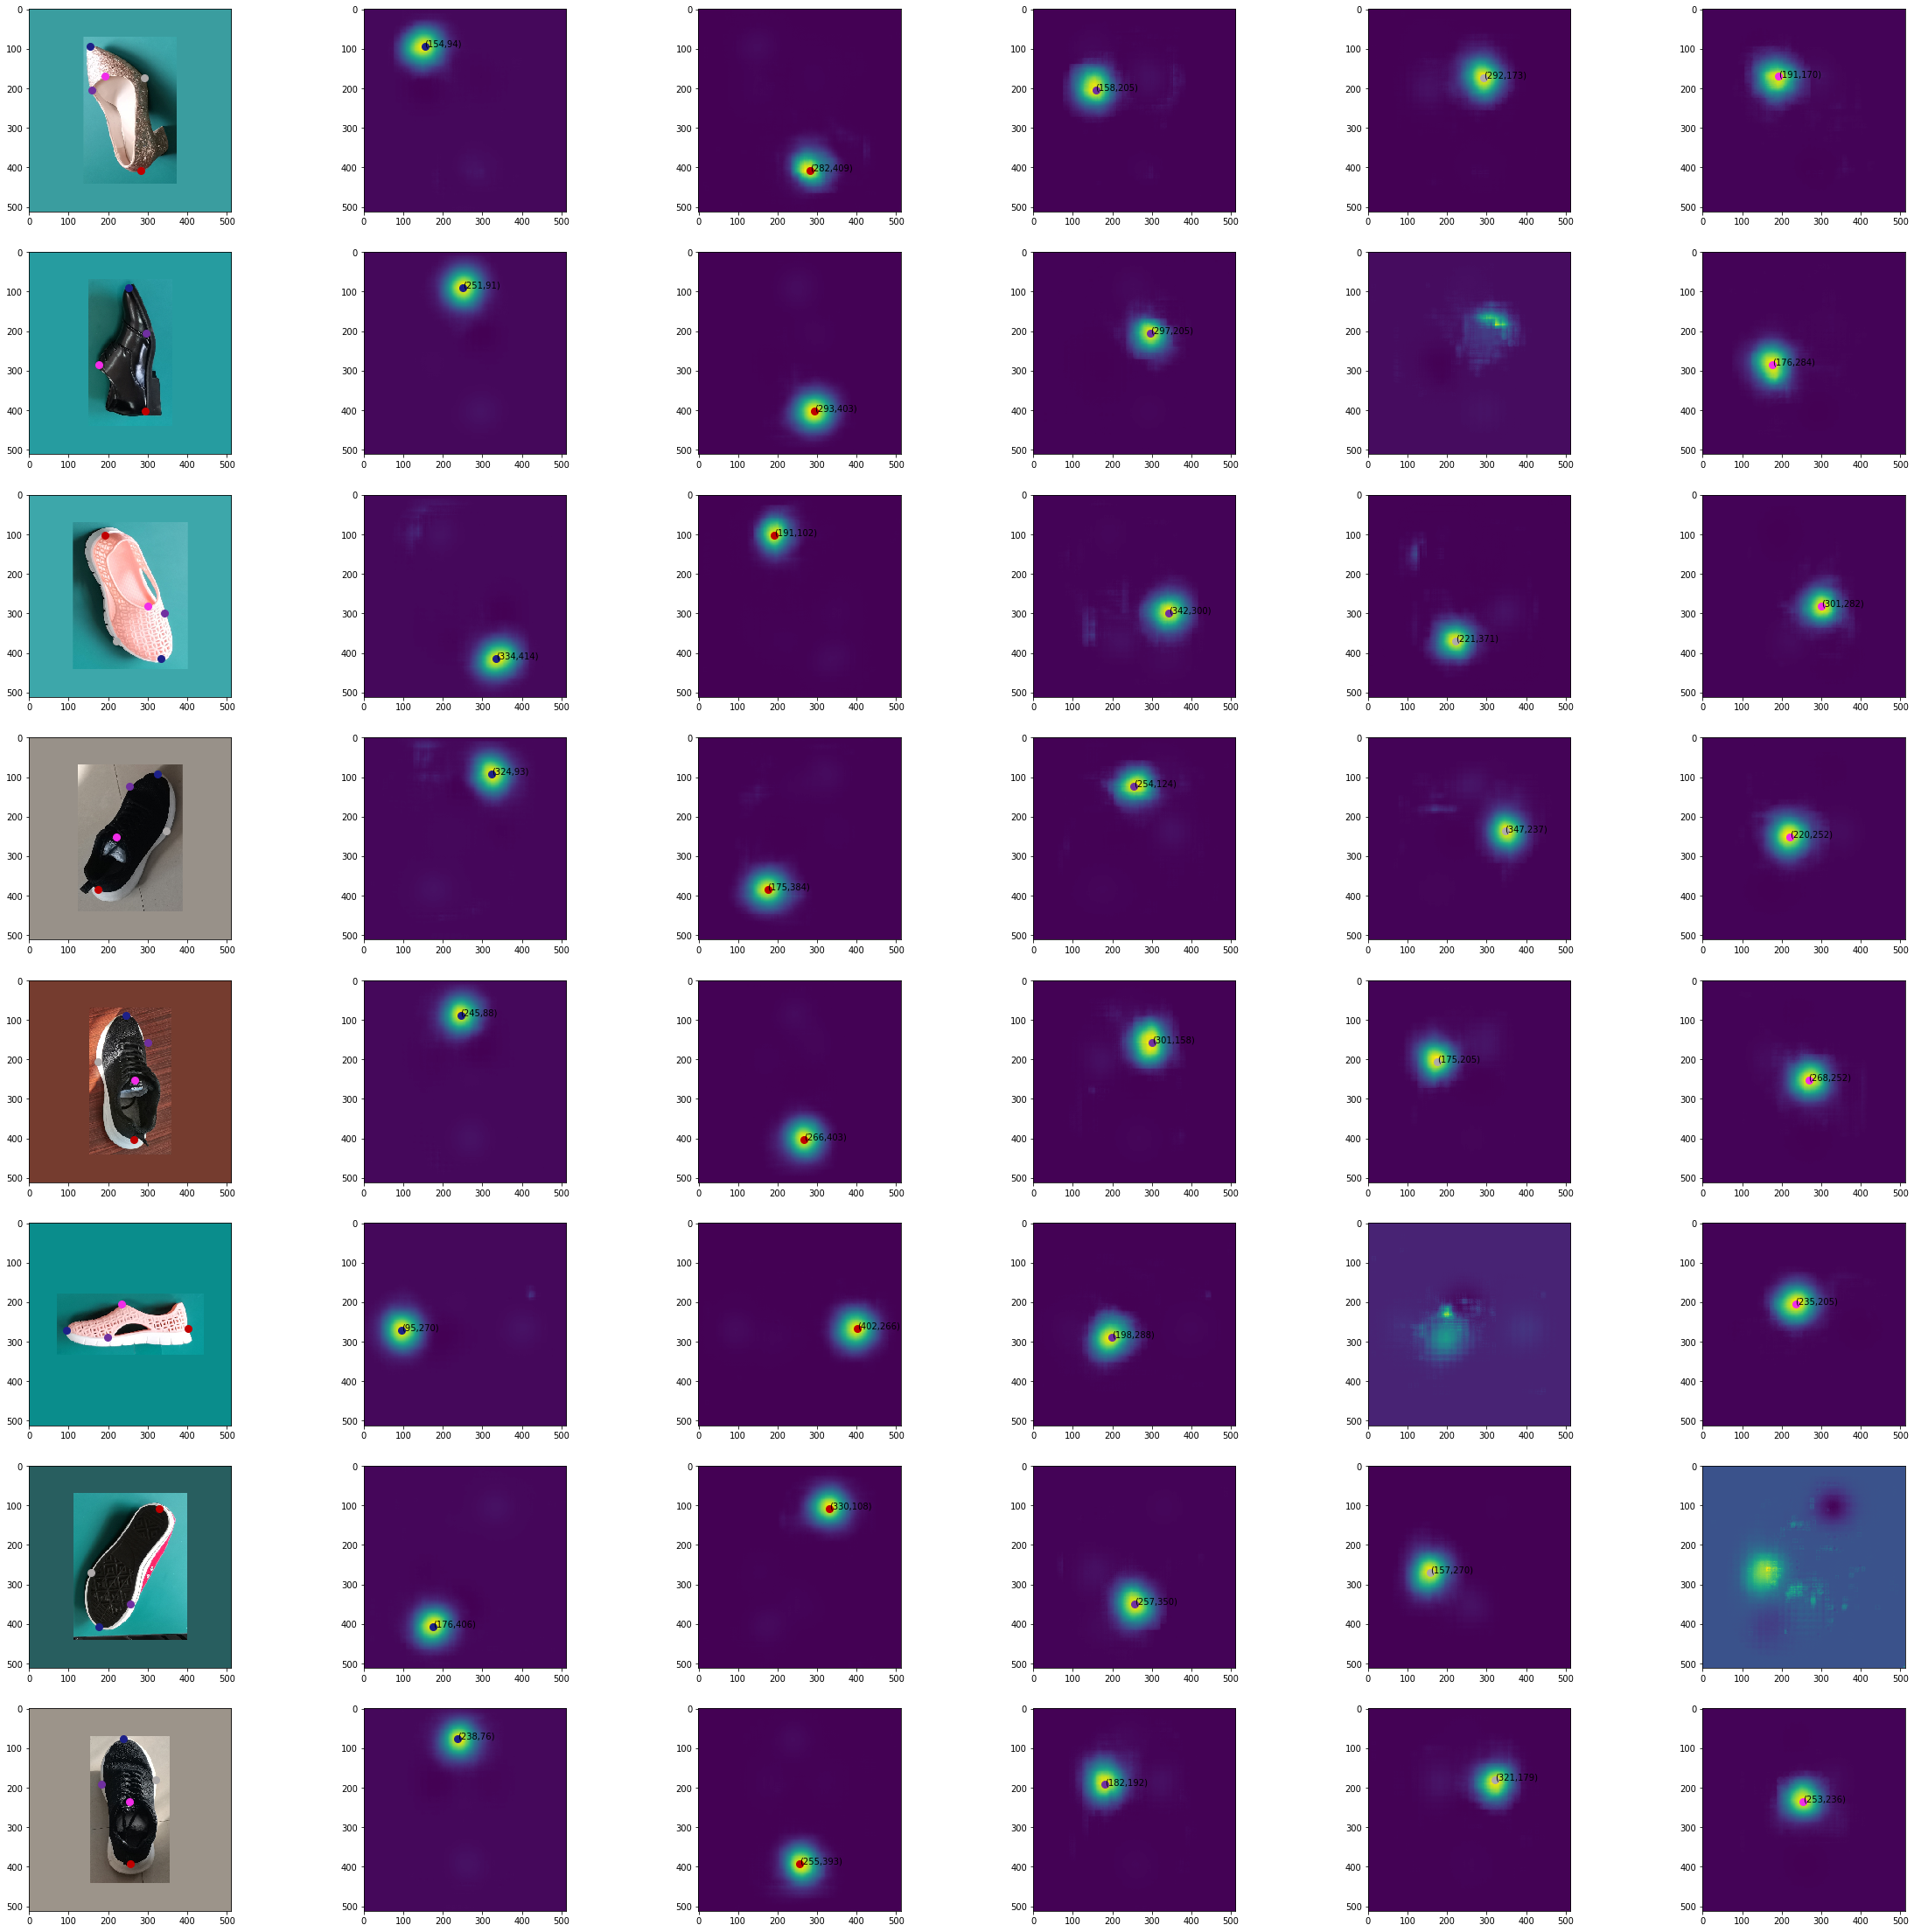

In [25]:
# 
def test(model, val_dataloader):
    model.eval()
    avg_loss_list = []
    cache = []  # ?
    with paddle.no_grad():
        for data in val_dataloader:
            imgs = (data[0] / 255.).astype("float32")
            labels = data[1].astype('float32')
            # print(data) # Tensor(shape=[batchsize, C, H, W]
            
            logits = model(imgs)
            # print(logits)  # Tensor(shape=[batchsize, output_dims]
            # Visualiztion
            # print(labels) # Tensor(shape=[batchsize, output_dims]
            
            for p, l in zip(logits.numpy(), labels.numpy()):
                cache.append([p, l])

            loss = cal_loss(logits, labels)
            avg_loss_list.append(loss.numpy()[0])

    cache = np.array(cache)
    ED = cal_ed_val(cache[:, 0], cache[:, 1])
    avg_loss = np.array(avg_loss_list).mean()

    return avg_loss, ED, logits, labels, imgs

## data augmentation with points when evaluation/validation
img_test_transforms = trans.ComposeWithPoint([
    trans.PaddedSquareWithPoints('constant'),  # may use 'edge' mode when testing in real scenes. 

    trans.RandomPadWithPoints(pad_thresh_l=0.384, pad_thresh_h=0.384)  # accroding to CropbyBBxinDarknet; # accroding to CropbyBBxinDarknet  pad_thresh_l=0.316, pad_thresh_h=0.412
])

test_dataset = imgDataset(image_file = test_filelists[66:74] ,  # ['TestingSet/IMG_20211207_113642.jpg','TestingSet/IMG_20211207_113724.jpg', 'TestingSet/IMG_20211207_113811.jpg'] images collected from real scenes
                        # pred_xy=pred_xy,
                       img_transforms = img_test_transforms,
                       label_file=label_file)

test_loader = paddle.io.DataLoader(
    test_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(test_dataset, batch_size=8, shuffle=False, drop_last=False),
    # num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

# # model= Network_resnet101v2()
# from grconvnet3_keypoint_paddle import GenerativeResnet  
# model = GenerativeResnet(input_channels=3, output_channels=5, channel_size=32,dropout=False, prob=0) # when testing, set dropout=False, prob=0.0
# from grconvnet3_keypoint_paddle import GenerativeResnet  
# model = GenerativeResnet(input_channels=3, output_channels=5, channel_size=64,dropout=False, prob=0) # when testing, set dropout=False, prob=0.0
# GResNet-Deeper
# from grconvnet3deeper_keypoint_paddle import GenerativeResnet
# model= GenerativeResnet(input_channels=3, output_channels=5, channel_size=32,dropout=False, prob=0)
# from grconvnet3deeper_keypoint_paddle import GenerativeResnet
# model= GenerativeResnet(input_channels=3, output_channels=5, channel_size=64,dropout=False, prob=0)
# GResNet-Deepest
from grconvnet3deepest_keypoint_paddle import GenerativeResnet_Deepest
model= GenerativeResnet_Deepest(input_channels=3, output_channels=5, channel_size=32,dropout=False, prob=0)
# # UNet
# from unet import UNet
# model = UNet(input_channels=3, num_classes=5)
# from unet2 import UNet
# model = UNet(input_channels=3, num_classes=5,in_channels = 64)
#GResNeXt
# from gresnext_keypoint_paddle import GenerativeResNeXt
# model = GenerativeResNeXt(input_channels=3, output_channels=5, channel_size=32,dropout=False, prob=0) 

# best_model_path = "trained_models/5Heatmap_GResNet-Deepest_C32_L2_ED_220226_2202/best_model_0.190171/model.pdparams"
# best_model_path = "trained_models/Heatmap_GResNet-Deepest_C32_L2_ED_220227_1135/best_model_0.020298/model.pdparams"
# best_model_path = "trained_models/7Heatmap_GResNet-Deepest_C32_L2_ED_220228_1102/best_model_0.011527/model.pdparams"
best_model_path = "trained_models/7Heatmap_GResNet-Deepest_C32_L2_ED_220228_1102/best_model_0.011527/model.pdparams"
# best_model_path = "trained_models/Heatmap_GResNeXt_C32_L2_ED_220222_2205/best_model_0.289125/model.pdparams"
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)

avg_loss, ED, logit, label, imgs= test(model,test_loader)  # the size of logits, label is (bacth, output_dims)
print("Avg ED for the given batch = {}".format(ED))

### visualize predicted results and corresponding ground truths of Testing Images
# the size of logits, label is (bacth, output_dims)
plt.figure(figsize=(40, 40)) # figsize=(20, 20)
colors = ['#1D2088', '#C00000','#7030A0','#AFABAB', '#F22CE9'] # blue, red, purple, grey, magenta
num =  logit.shape[0] # 8
for i in range(num):
    # special cases:16
    # img, lab = val_dataset.__getitem__(180+i)  
    img=imgs[i].numpy() # transfer paddle.Tensor to numpy.ndarray
    lab=label[i]
    pre = logit[i]

    plt.subplot(num, 6, 6*i+1)
    plt.imshow(img.transpose(1, 2, 0)) # C, H, W → H, W, C
    
    # visualize the heatmaps
    for j in range(logit.shape[1]):  # logit.shape[1]==5
        plt.subplot(num,6,6*i+j+2)
        # plt.imshow(lab[j])
        plt.imshow(pre[j])
        if pre[j].max() >= 0.75:
            # kx= np.where(lab[j]==lab[j].max())[1][0]
            # ky= np.where(lab[j]==lab[j].max())[0][0]
            kx_p= np.where(pre[j]==pre[j].max())[1][0]
            ky_p= np.where(pre[j]==pre[j].max())[0][0]
            # print('x={}, y={}'.format(kx_p,ky_p))
            # print(heatmap1[y,x])
            plt.plot(kx_p, ky_p,'.', color=colors[j], markersize=16) #  markersize=8
            plt.text(kx_p, ky_p, "({},{})".format(kx_p,ky_p))
            plt.subplot(num, 6, 6*i+1)
            plt.plot(kx_p, ky_p,'.', color=colors[j], markersize=16)

In [86]:
print([logit[0][0].max(), logit[0][1].max(), logit[0][2].max(),logit[0][3].max(),logit[0][4].max()])
print([logit[1][0].max(), logit[1][1].max(), logit[1][2].max(),logit[1][3].max(),logit[1][4].max()])

[Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.97355729]), Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.87723833]), Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.90123832]), Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.79250669]), Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.93638915])]
[Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.98453403]), Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.93956840]), Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.90095770]), Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.88592362]), Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [0.95087183])]


In [13]:
h=512
w=512
i=0
kx_i= np.where(logit[i][2]==logit[i][2].max())[1][0]  # predicted inside keypoint
ky_i= np.where(logit[i][2]==logit[i][2].max())[0][0]
kx_o= np.where(logit[i][3]==logit[i][3].max())[1][0]  # predicted outside keypoint
ky_o= np.where(logit[i][3]==logit[i][3].max())[0][0]
# calculate euclidean_distances by normalizad kx, ky
ed_io = euclidean_distances([[kx_i/w, ky_i/h]],[[kx_o/w, ky_o/h]]) # 2D arrays are expected
print(ed_io)

[[0.22705026]]


In [9]:
img_test_transforms = trans.ComposeWithPoint([
    trans.PaddedSquareWithPoints('constant'),  # may use 'edge' mode when testing in real scenes. 
    trans.RandomPadWithPoints(pad_thresh_l=0.384, pad_thresh_h=0.384)  # accroding to CropbyBBxinDarknet; # accroding to CropbyBBxinDarknet  pad_thresh_l=0.316, pad_thresh_h=0.412
])
test_dataset = imgDataset(image_file = test_filelists,  # images collected from real scenes
                        # pred_xy=pred_xy,
                       img_transforms = img_test_transforms,
                       label_file=label_file)

test_loader = paddle.io.DataLoader(
    test_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(test_dataset, batch_size=8, shuffle=False, drop_last=False),
    # num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    avg_loss, ED, logit, label, imgs= test(model,test_loader)  # the size of logits, label is (bacth, output_dims)
print("Avg ED for the whole Testing set = {}".format(ED)) # [[0.01662511]]

Avg ED for the whole Testing set = [[0.01662511]]


In [30]:
len(test_filelists)

190

In [27]:
logit.shape

[6, 5, 512, 512]

## Post-processing 1: Keypoint-based Pose Classification  
The top, side, bottom poses are defined by existence of keypoints:
* top: all defined five keypoints are existing (detected)
* side: four keypoints are detected with only one side keypoint
* bottom: four keypoints are detected without the topline keypoint

The poses of imgs below were unrecognized:[]
[Keypoint-based Pose Classification] kappa=0.9111, macro_recall=0.9400, accuracy=0.9421,macro_precision=0.9547 weighted_precision=0.9457
[[0.94318182 0.07894737 0.        ]
 [0.03409091 0.92105263 0.        ]
 [0.02272727 0.         1.        ]]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass display_labels=['top', 'side', 'bottom'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


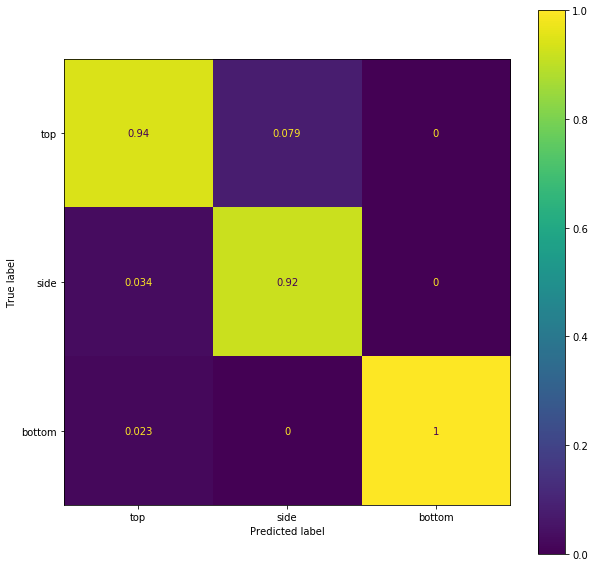

In [26]:
## Evaluation function for keypoint-based pose classification
## The top, side, bottom poses are defined by existence of keypoints:
## * top: all defined five keypoints are existing (detected)
## * side: four keypoints are detected with only one side keypoint
## * bottom: four keypoints are detected without the topline keypoint 
def pose_classify(model, test_dataloader, pose_labels, kp_thresh = 0.794, ed_c = 0.855, io_thresh=0.08): # ed_thresh=0.18, # method 6 is the best, while method 2 and method 7 are good 
    model.eval()
    # logits = []
    # imgs = []
    pose_classes = []
    unrecognized_pose = []

    with paddle.no_grad(): 
        for data in test_dataloader:  #  img, idx, h, w, fh, fw
            img_name = data[1]  # ['TestingSet/IMG_20211207_113940.jpg']

            imgs = (data[0] / 255.).astype("float32")
            logits = model(imgs)
            # print(logits)


            kp_peaks = np.array([logits[0][0].max(), logits[0][1].max(), logits[0][2].max(),logits[0][3].max(),logits[0][4].max()]) # the heatmap max values of 5 keypoints at toe, heel, inside, outside, topline
            # method 6 is the best, while method 2 and method 7 are good 

            # method 6: kp_thresh + argmin + relative euclidean_distance # optimal ed_c=0.855, kp_thresh = 0.794 for method 6, then macro_precision=0.9547 weighted_precision=0.9457
            h= logits.shape[2]
            w= logits.shape[3]
            kx_i= np.where(logits[0][2]==logits[0][2].max())[1][0]  # predicted inside keypoint
            ky_i= np.where(logits[0][2]==logits[0][2].max())[0][0]
            kx_o= np.where(logits[0][3]==logits[0][3].max())[1][0]  # predicted outside keypoint
            ky_o= np.where(logits[0][3]==logits[0][3].max())[0][0]

            # calculate euclidean_distances by normalizad kx, ky
            ed_io = euclidean_distances([[kx_i/w, ky_i/h]],[[kx_o/w, ky_o/h]]) # 2D arrays are expected 
            
            kx_toe= np.where(logits[0][0]==logits[0][0].max())[1][0]  # predicted toe keypoint
            ky_toe= np.where(logits[0][0]==logits[0][0].max())[0][0]
            ed_it = euclidean_distances([[kx_i/w, ky_i/h]],[[kx_toe/w, ky_toe/h]]) # 2D arrays are expected 
            ed_ot = euclidean_distances([[kx_o/w, ky_o/h]],[[kx_toe/w, ky_toe/h]]) # 2D arrays are expected
            ed_thresh = min(ed_it, ed_ot)*ed_c # ed_c coefficient
            
            if kp_peaks.min() < kp_thresh:
                if kp_peaks.argmin() == 4:
                    pose_classes.append([pose_labels[img_name[0]], 2]) # 2 stands for bottom 
                elif kp_peaks.argmin() == 3 or kp_peaks.argmin() == 2:
                    pose_classes.append([pose_labels[img_name[0]], 1])  # 1 stands for side
                else:  # kp_peaks.argmin() == 0 or kp_peaks.argmin() == 1 
                    pose_classes.append([pose_labels[img_name[0]], 0])
            else:  # kp_peaks.min() > kp_thresh or  kp_peaks.min() = kp_thresh
                if ed_io < ed_thresh:  
                    pose_classes.append([pose_labels[img_name[0]], 1])  # 1 stands for side
                else: # ed_io >= ed_thresh
                    pose_classes.append([pose_labels[img_name[0]], 0])  # 0 stands for top
            
            # # method 2: kp_thresh + argmin # optimal kp_thresh = 0.794 for method 2, then macro_precision=0.9088 weighted_precision=0.8906, precision for top, side, bottom is 0.8218, 0.9048, 1.0000 
            # if kp_peaks.min() < kp_thresh:
            #     if kp_peaks.argmin() == 4:
            #         pose_classes.append([pose_labels[img_name[0]], 2]) # 2 stands for bottom 
            #     elif kp_peaks.argmin() == 3 or kp_peaks.argmin() == 2:
            #         pose_classes.append([pose_labels[img_name[0]], 1])  # 1 stands for side
            #     else:  # kp_peaks.argmin() == 0 or kp_peaks.argmin() == 1 
            #         pose_classes.append([pose_labels[img_name[0]], 0])
            # else:  # kp_peaks.min() > kp_thresh or  kp_peaks.min() = kp_thresh
            #     pose_classes.append([pose_labels[img_name[0]], 0])  # 0 stands for top

            # method 1: kp_thresh + argmin + unrecognized pose
            # if kp_peaks.min() < kp_thresh:
            #     if kp_peaks.argmin() == 4:
            #         pose_classes.append([pose_labels[img_name[0]], 2]) # 2 stands for bottom 
            #     elif kp_peaks.argmin() == 3 or kp_peaks.argmin() == 2:
            #         pose_classes.append([pose_labels[img_name[0]], 1])  # 1 stands for side
            #     else:  # kp_peaks.argmin() == 0 or kp_peaks.argmin() == 1 
            #         unrecognized_pose.append(img_name[0])
            # else:  # kp_peaks.min() > kp_thresh or  kp_peaks.min() = kp_thresh
            #     pose_classes.append([pose_labels[img_name[0]], 0])  # 0 stands for top

            # method 3: kp_thresh + argmin + io_thresh (threshold between inside and outside point)
            # if kp_peaks.min() < kp_thresh:
            #     if kp_peaks.argmin() == 4:
            #         pose_classes.append([pose_labels[img_name[0]], 2]) # 2 stands for bottom 
            #     elif kp_peaks.argmin() == 3 or kp_peaks.argmin() == 2 or abs(kp_peaks[2]-kp_peaks[3]) > io_thresh:
            #         pose_classes.append([pose_labels[img_name[0]], 1])  # 1 stands for side
            #     else:  # kp_peaks.argmin() == 0 or kp_peaks.argmin() == 1 
            #         pose_classes.append([pose_labels[img_name[0]], 0])
            # else:  # kp_peaks.min() > kp_thresh or  kp_peaks.min() = kp_thresh
            #     pose_classes.append([pose_labels[img_name[0]], 0])  # 0 stands for top
            
            # # method 4: argmin
            # if kp_peaks.argmin() == 4:
            #     pose_classes.append([pose_labels[img_name[0]], 2]) # 2 stands for bottom 
            # elif kp_peaks.argmin() == 3 or kp_peaks.argmin() == 2:
            #     pose_classes.append([pose_labels[img_name[0]], 1])  # 1 stands for side
            # else:  # kp_peaks.argmin() == 0 or kp_peaks.argmin() == 1 
            #     pose_classes.append([pose_labels[img_name[0]], 0])

            # # method 7: argmin + relative euclidean_distance # optimal ed_c=0.935 for method 7, then macro_precision=0.8844 weighted_precision=0.8747
            # h= logits.shape[2]
            # w= logits.shape[3]
            # kx_i= np.where(logits[0][2]==logits[0][2].max())[1][0]  # predicted inside keypoint
            # ky_i= np.where(logits[0][2]==logits[0][2].max())[0][0]
            # kx_o= np.where(logits[0][3]==logits[0][3].max())[1][0]  # predicted outside keypoint
            # ky_o= np.where(logits[0][3]==logits[0][3].max())[0][0]

            # # calculate euclidean_distances by normalizad kx, ky
            # ed_io = euclidean_distances([[kx_i/w, ky_i/h]],[[kx_o/w, ky_o/h]]) # 2D arrays are expected 
            
            # kx_toe= np.where(logits[0][0]==logits[0][0].max())[1][0]  # predicted inside keypoint
            # ky_toe= np.where(logits[0][0]==logits[0][0].max())[0][0]
            # ed_it = euclidean_distances([[kx_i/w, ky_i/h]],[[kx_toe/w, ky_toe/h]]) # 2D arrays are expected 
            # ed_ot = euclidean_distances([[kx_o/w, ky_o/h]],[[kx_toe/w, ky_toe/h]]) # 2D arrays are expected
            # ed_thresh = min(ed_it, ed_ot)*ed_c # ed_c coefficient

            # if kp_peaks.argmin() == 4:
            #     pose_classes.append([pose_labels[img_name[0]], 2]) # 2 stands for bottom 
            # elif (kp_peaks.argmin() == 3 or kp_peaks.argmin() == 2) and ed_io < ed_thresh:
            #     pose_classes.append([pose_labels[img_name[0]], 1])  # 1 stands for side
            # else:  # kp_peaks.argmin() == 0 or kp_peaks.argmin() == 1 
            #     pose_classes.append([pose_labels[img_name[0]], 0])

            # # method 8: argmin + io_thresh # 
            # if kp_peaks.argmin() == 4:
            #     pose_classes.append([pose_labels[img_name[0]], 2]) # 2 stands for bottom 
            # elif abs(kp_peaks[2]-kp_peaks[3]) > io_thresh and (kp_peaks.argmin() == 3 or kp_peaks.argmin() == 2):
            #     pose_classes.append([pose_labels[img_name[0]], 1])  # 1 stands for side
            # else:  # kp_peaks.argmin() == 0 or kp_peaks.argmin() == 1 
            #     pose_classes.append([pose_labels[img_name[0]], 0])
            
    pose_classes = np.array(pose_classes)
    kappa = cohen_kappa_score(pose_classes[:, 0], pose_classes[:, 1], weights='quadratic')
    cfs_matrix =  confusion_matrix(pose_classes[:, 0], pose_classes[:, 1],normalize='pred') #  ,normalize='true'
    weighted_precision = 0.4*cfs_matrix[0,0]+0.4*cfs_matrix[1,1]+0.2*cfs_matrix[2,2]

    # two methods to calculate macro_precision
    # macro_precision = (cfs_matrix[0,0]+cfs_matrix[1,1]+cfs_matrix[2,2])/3
    macro_precision =  precision_score(pose_classes[:, 0], pose_classes[:, 1],average='macro')
    macro_recall = recall_score(pose_classes[:, 0], pose_classes[:, 1],average='macro')
    accuracy = accuracy_score(pose_classes[:, 0], pose_classes[:, 1])

    return unrecognized_pose, kappa, macro_recall, accuracy, macro_precision, weighted_precision, cfs_matrix

# data augmentation without points when predicting/testing
img_test_transforms = trans.Compose([
    trans.PaddedSquare('constant'),  # may use 'edge' mode when testing in real scenes. 
    # trans.RandomHVFlip(),
    # trans.ColorJitter(0.1, 0.1, 0.1, 0.1),
    trans.RandomPadWithoutPoints(pad_thresh_l=0.384, pad_thresh_h=0.384)  # accroding to CropbyBBxinDarknet; # accroding to CropbyBBxinDarknet  pad_thresh_l=0.316, pad_thresh_h=0.412
])
test_dataset = imgDataset(image_file = test_filelists,  # images collected from real scenes
                        # pred_xy=pred_xy,
                       img_transforms = img_test_transforms,
                       mode='test')  # change the mode to 'test' 

test_loader = paddle.io.DataLoader(
    test_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(test_dataset, batch_size=1, shuffle=False, drop_last=False), # batch_size=1, to detect the keypoint one img by one img
    # num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

# GResNet-Deepest
from grconvnet3deepest_keypoint_paddle import GenerativeResnet_Deepest
model= GenerativeResnet_Deepest(input_channels=3, output_channels=5, channel_size=32,dropout=False, prob=0)
best_model_path = "trained_models/8_3Heatmap_GResNet-Deepest_C32_no_TestSet_finetune_220315_1219/best_model_0.016625/model.pdparams"
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)

pose_label_file = "ShoesStatesTestingGT.xls" # the number of shoe testing images in top, side, bottom is 89, 73, 28 respectively  
pose_labels = {os.path.join(testset_root, row['img_name']): row[1:].values.argmax()
                        for _, row in pd.read_excel(pose_label_file).iterrows()}  # {img_name: flag}, flag is 0 or 1 or 2, which represents top, side, bottom respectively

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    unrecognized_pose, kappa, macro_recall, accuracy, macro_precision, weighted_precision, cfs_matrix = pose_classify(model,test_loader,pose_labels, kp_thresh = 0.794,ed_c=0.855,io_thresh=0.08)  # ed_thresh=0.18, the size of logits, label is (bacth, output_dims)

print("The poses of imgs below were unrecognized:{}".format(unrecognized_pose))
print("[Keypoint-based Pose Classification] kappa={:.4f}, macro_recall={:.4f}, accuracy={:.4f},macro_precision={:.4f} weighted_precision={:.4f}".format(kappa, macro_recall, accuracy, macro_precision, weighted_precision))
print(cfs_matrix)
fig, ax = plt.subplots(figsize=(10,10))  # ,values_format='.4g'
ConfusionMatrixDisplay(cfs_matrix.round(4), ['top','side','bottom']).plot(ax=ax)


In [50]:
# Inference function for keypoint-based pose classification
def pose_classify_infer(model, imgs, kp_thresh = 0.794, ed_c = 0.855): # method 6 is the best 
    model.eval()
    with paddle.no_grad(): 

        logits = model(imgs)

        kp_peaks = np.array([logits[0][0].max(), logits[0][1].max(), logits[0][2].max(),logits[0][3].max(),logits[0][4].max()]) # the heatmap max values of 5 keypoints at toe, heel, inside, outside, topline
        # method 6: kp_thresh + argmin + relative euclidean_distance # optimal ed_c=0.855, kp_thresh = 0.794 for method 6, then macro_precision=0.9547 weighted_precision=0.9457
        h= logits.shape[2]
        w= logits.shape[3]
        kx_i= np.where(logits[0][2]==logits[0][2].max())[1][0]  # predicted inside keypoint
        ky_i= np.where(logits[0][2]==logits[0][2].max())[0][0]
        kx_o= np.where(logits[0][3]==logits[0][3].max())[1][0]  # predicted outside keypoint
        ky_o= np.where(logits[0][3]==logits[0][3].max())[0][0]

        # calculate euclidean_distances by normalizad kx, ky
        ed_io = euclidean_distances([[kx_i/w, ky_i/h]],[[kx_o/w, ky_o/h]]) # 2D arrays are expected 
        
        kx_toe= np.where(logits[0][0]==logits[0][0].max())[1][0]  # predicted toe keypoint
        ky_toe= np.where(logits[0][0]==logits[0][0].max())[0][0]
        ed_it = euclidean_distances([[kx_i/w, ky_i/h]],[[kx_toe/w, ky_toe/h]]) # 2D arrays are expected 
        ed_ot = euclidean_distances([[kx_o/w, ky_o/h]],[[kx_toe/w, ky_toe/h]]) # 2D arrays are expected
        ed_thresh = min(ed_it, ed_ot)*ed_c # ed_c coefficient
        
        if kp_peaks.min() < kp_thresh:
            if kp_peaks.argmin() == 4:
                return 2 # 2 stands for bottom 
            elif kp_peaks.argmin() == 3 or kp_peaks.argmin() == 2:
                return 1 # 1 stands for side
            else:  # kp_peaks.argmin() == 0 or kp_peaks.argmin() == 1 
                return 0 
        else:  # kp_peaks.min() > kp_thresh or  kp_peaks.min() = kp_thresh
            if ed_io < ed_thresh:  
                return 1 # 1 stands for side
            else: # ed_io >= ed_thresh
                return 0  # 0 stands for top

for data in test_loader:
    img_name = data[1]
    print(img_name)
    imgs = (data[0] / 255.).astype("float32")
    print(pose_classify_infer(model,imgs))

['TestingSet/IMG_20211207_113940.jpg']
0
['TestingSet/IMG_20211207_113948.jpg']
0
['TestingSet/IMG_20211207_141906.jpg']
0
['TestingSet/IMG_20211207_144805_1.jpg']
1
['TestingSet/IMG_20210302_151418.jpg']
0
['TestingSet/IMG_20211207_141617.jpg']
2
['TestingSet/IMG_20211207_141440.jpg']
0
['TestingSet/IMG_20211207_143515_1.jpg']
1
['TestingSet/IMG_20211207_113923.jpg']
0
['TestingSet/IMG_20211207_141654.jpg']
2
['TestingSet/IMG_20210302_143744.jpg']
0
['TestingSet/IMG_20211207_113642.jpg']
0
['TestingSet/IMG_20211207_141936.jpg']
1
['TestingSet/IMG_20211207_141902.jpg']
0
['TestingSet/IMG_20211207_141945.jpg']
1
['TestingSet/IMG_20210302_143620.jpg']
0
['TestingSet/IMG_20210302_144731.jpg']
1
['TestingSet/IMG_20210302_143517.jpg']
0
['TestingSet/IMG_20210302_145011.jpg']
0
['TestingSet/IMG_20210302_151820.jpg']
0
['TestingSet/IMG_20211207_113823.jpg']
2
['TestingSet/IMG_20211207_141750.jpg']
0
['TestingSet/IMG_20211207_141559.jpg']
1
['TestingSet/IMG_20211207_143616_1.jpg']
2
['TestingS

In [40]:
## 90, 73, 28
count =0
for i in pose_labels.keys():
    if pose_labels[i] ==0:
        count = count +1 
print(count)

90


In [12]:
pose_label_file = "ShoesStatesTestingGT.xls"
pose_labels = {os.path.join(testset_root, row['img_name']): row[1:].values.argmax()
                        for _, row in pd.read_excel(pose_label_file).iterrows()}
print(pose_labels['TestingSet/IMG_20211207_113712.jpg'])

0


In [53]:
a=np.array([1,2,3,4])
print(a.argmin(), a.min())
print(a.argmax(), a.max())

0 1
3 4


In [18]:
abs(np.array([0.6])-np.array([0.8]))

array([0.2])

## Post-processing 2: Keypoint-based Pose Estimation 

In [10]:
# Define testing dataloader and import trained model
## data augmentation with points when evaluation/validation

img_test_transforms = trans.ComposeWithPoint([
    trans.PaddedSquareWithPoints('constant'),  # may use 'edge' mode when testing in real scenes. 
    trans.RandomPadWithPoints(pad_thresh_l=0.384, pad_thresh_h=0.384)  # accroding to CropbyBBxinDarknet; # accroding to CropbyBBxinDarknet  pad_thresh_l=0.316, pad_thresh_h=0.412
])
test_dataset = imgDataset(image_file = test_filelists, # test_filelists train_filelists [test_filelists[11], test_filelists[167], test_filelists[107], test_filelists[155], test_filelists[5], test_filelists[113]], # images collected from real scenes
                        # pred_xy=pred_xy,
                       img_transforms = img_test_transforms,
                       label_file=label_file,
                       index_mode=True)

test_loader = paddle.io.DataLoader(
    test_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(test_dataset, batch_size=1, shuffle=False, drop_last=False),
    # num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

## GResNet-Deepest
from grconvnet3deepest_keypoint_paddle import GenerativeResnet_Deepest
model= GenerativeResnet_Deepest(input_channels=3, output_channels=5, channel_size=32,dropout=False, prob=0)
#best_model_path = "trained_models/8_3Heatmap_GResNet-Deepest_C32_no_TestSet_finetune_220315_1219/best_model_0.016625/model.pdparams"
best_model_path = "trained_models/7Heatmap_GResNet-Deepest_C32_L2_ED_220228_1102/best_model_0.011527/model.pdparams"
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)

# yaw_labels
# roll_label

W0620 17:28:29.104072 12337 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0620 17:28:29.108434 12337 device_context.cc:465] device: 0, cuDNN Version: 7.6.


In [ ]:
type(test_filelists[189]) 

In [11]:
# Evaluate keypoint-based yaw angle prediction
# convert image coordinate system to object right-hand coordinate system
"""
# right-hand coordinate system 0
def img_to_object_r_coor(w,h,x,y):
    '''
    convert image coordinate system to object right-hand coordinate system
    return np.array
    '''
    z1 = w - x
    x1 = h - y    
    return np.array([z1, x1])
"""
# right-hand coordinate system 1
def img_to_object_r_coor(w,h,x,y):
    '''
    convert image coordinate system to object right-hand coordinate system
    return np.array
    '''
    x1= h - y
    y1= x    
    return np.array([x1, y1])
# calculate yaw
def yaw_cal(HT0, HT):
    HT_cross = np.cross(HT0,HT)
    HT_dot   = np.dot(HT0,HT)
    yaw = np.arctan2(HT_cross, HT_dot)*180/np.pi # arctan2 is identical to the atan2 function of the underlying C library.
    return yaw

# Evaluate the performance by average yaw error 
def yaw_eval(model, test_dataloader): # ed_thresh=0.18, # method 6 is the best, while method 2 and method 7 are good 
    model.eval()

    yaw_errors_list = []
    img_name_list = [] # 'IMG_20211207_113928.jpg'
    yaw_label_list = []
    yaw_pred_list = []
    # yaw_errors_relative_list = []

    with paddle.no_grad(): 
        for data in test_dataloader:  #  img, idx, h, w, fh, fw
            imgs = (data[0] / 255.).astype("float32")
            labels = data[1].astype('float32')
            img_name_list.append(data[2][0].split('/')[-1]) # data[2] is like ['TestingSet/IMG_20211207_113928.jpg']
            #print(data[2])

            logits = model(imgs)
            # print(logits)

            h= logits.shape[2]
            w= logits.shape[3]

            ## Get predicted keypoints and predicted yaw
            kx_toe=  np.where(logits[0][0]==logits[0][0].max())[1][0]  # predicted toe keypoint
            ky_toe=  np.where(logits[0][0]==logits[0][0].max())[0][0]
            kx_heel= np.where(logits[0][1]==logits[0][1].max())[1][0]  # predicted heel keypoint
            ky_heel= np.where(logits[0][1]==logits[0][1].max())[0][0]

            Toe  = img_to_object_r_coor(w,h,kx_toe, ky_toe)
            Heel = img_to_object_r_coor(w,h,kx_heel,ky_heel)
            HT = Toe - Heel
            # HT0 =  np.array([0, 10]) # (z1, x1)
            HT0 =  np.array([10, 0]) # (x1, y1)
            yaw_pred = yaw_cal(HT0, HT)
            yaw_pred_list.append(yaw_pred)

            ## Get labelled keypoints and labelled yaw
            lx_toe = np.where(labels[0][0]==labels[0][0].max())[1][0]  # predicted toe keypoint
            ly_toe = np.where(labels[0][0]==labels[0][0].max())[0][0]
            lx_heel= np.where(labels[0][1]==labels[0][1].max())[1][0]  # predicted heel keypoint
            ly_heel= np.where(labels[0][1]==labels[0][1].max())[0][0]
            Toe_l  = img_to_object_r_coor(w,h,lx_toe, ly_toe)
            Heel_l = img_to_object_r_coor(w,h,lx_heel,ly_heel)
            HT_l = Toe_l - Heel_l
            # HT0 =  np.array([0, 10]) # (z1, x1)
            HT0 =  np.array([10, 0]) # (x1, y1)
            yaw_label =  yaw_cal(HT0, HT_l)
            yaw_label_list.append(yaw_label)

            # Method 1 for calculating yaw errors
            yaw_error = abs(yaw_pred- yaw_label)   # a positive number 
            if yaw_error>180:
                yaw_error = 360 - yaw_error
            yaw_errors_list.append(yaw_error)
            # print(yaw_error)

            # Indentical Method 2 for calculating yaw errors
            # yaw_error =  abs(yaw_cal(HT, HT_l))
            # yaw_errors_list.append(yaw_error)

    avg_yaw_error =  sum(yaw_errors_list)/len(yaw_errors_list)
    return avg_yaw_error, yaw_errors_list, img_name_list, yaw_label_list, yaw_pred_list

# Evaluate the performance by Average Precision at y° yaw error
def AP_at_yaw(yaw_errors_list, yaw_threshs):
    # yaw_threshs = [7,6,5,4,3,2,1]
    for yaw_thresh in yaw_threshs:
        # Method 1 for calculate AP@yaw° error
        # print(sum(i>yaw_thresh for i in yaw_errors_list))
        print("[Keypoint-based Pose Estimation] Average Presicion at {}° yaw error is {:.4f}".format(yaw_thresh, 1-sum(i>yaw_thresh for i in yaw_errors_list)/len(yaw_errors_list)))
        
        # Identical Method 2 for calculate AP@yaw° error
        # print("Average Presicion at {}° yaw error is {:.4f}".format(yaw_thresh, 1-len([i for i in yaw_errors_list if i>yaw_thresh])/len(yaw_errors_list)))
        # Identical Method 3 for calculate AP@yaw° error
        # np.sum(np.array(yaw_errors_list)>yaw_thresh)
        # Identical Method 4 for calculate AP@yaw° error
        # error_count = 0
        # for i in yaw_errors_list: # yaw_errors_relative_list
        #     if i >=yaw_thresh:
        #         print(i)
        #         error_count = error_count +1
        

avg_yaw_error, yaw_errors_list,img_name_list, yaw_label_list, yaw_pred_list = yaw_eval(model, test_loader)
print("[Keypoint-based Pose Estimation] Average yaw error ={:.4f}°,".format(avg_yaw_error)) # Average yaw error
AP_at_yaw(yaw_errors_list, [7,6,5,4,3,2,1])  # AP@yaw° error



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


[Keypoint-based Pose Estimation] Average yaw error =1.0899°,
[Keypoint-based Pose Estimation] Average Presicion at 7° yaw error is 1.0000
[Keypoint-based Pose Estimation] Average Presicion at 6° yaw error is 0.9947
[Keypoint-based Pose Estimation] Average Presicion at 5° yaw error is 0.9947
[Keypoint-based Pose Estimation] Average Presicion at 4° yaw error is 0.9842
[Keypoint-based Pose Estimation] Average Presicion at 3° yaw error is 0.9632
[Keypoint-based Pose Estimation] Average Presicion at 2° yaw error is 0.8526
[Keypoint-based Pose Estimation] Average Presicion at 1° yaw error is 0.5474


In [25]:
pip install xlwt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 KB 4.2 MB/s eta 0:00:00
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
# save the yaw_label and yaw_pred in a spreadsheet
import os
import shutil
import xlwt   # xlrd, xlutils

obj=xlwt.Workbook(encoding='utf-8',style_compression=0)
sheet=obj.add_sheet('cropped_shoes_yaws',cell_overwrite_ok=True)

sheet.col(0).width=512*20
sheet.write(0,0,'img_name')    # write(row,col,value)
sheet.write(0,1,'yaw_label')
sheet.write(0,2,'yaw_KPNet_pred')
#sheet.write(0,3,'yaw_CenterPose_pred')

row_idx = 1

for ti in range(len(img_name_list)):
    sheet.write(row_idx+ti,0,img_name_list[ti])
    sheet.write(row_idx+ti,1,yaw_label_list[ti])
    sheet.write(row_idx+ti,2,yaw_pred_list[ti])

obj.save("ShoesYaws.xls")

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero e

[Keypoint-based Pose Estimation] Average roll error =4.2632°,
[Keypoint-based Pose Estimation] Average Presicion at 180° roll error is 0.9947
[Keypoint-based Pose Estimation] Average Presicion at 90° roll error is 0.9895
[Keypoint-based Pose Estimation] Average Presicion at 5° roll error is 0.9684
[Keypoint-based Pose Estimation] Average Presicion at 4° roll error is 0.9684
[Keypoint-based Pose Estimation] Average Presicion at 3° roll error is 0.9684
[Keypoint-based Pose Estimation] Average Presicion at 2° roll error is 0.9684
[Keypoint-based Pose Estimation] Average Presicion at 1° roll error is 0.9684
[left-right classification] macro_recall=0.9534, accuracy=0.9579,macro_precision=0.9605 average_precision=0.9605
[[0.97368421 0.05263158]
 [0.02631579 0.94736842]]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass display_labels=['left', 'right'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


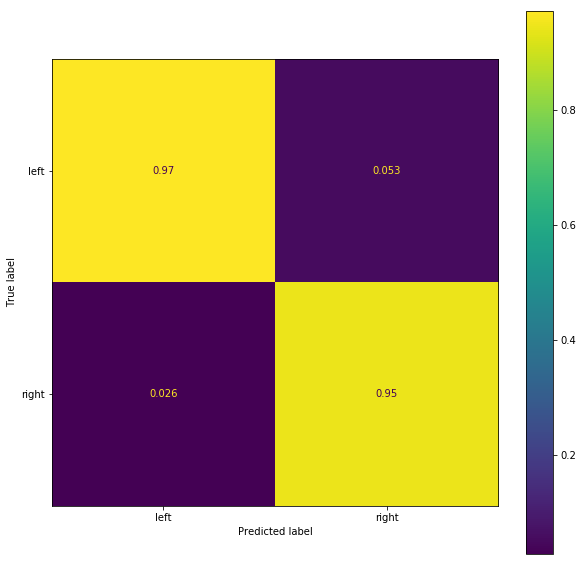

In [14]:
# Inference function for keypoint-based pose classification
def pose_classify_infer(logits, kp_thresh = 0.794, ed_c = 0.855): # method 6 is the best 

    kp_peaks = np.array([logits[0][0].max(), logits[0][1].max(), logits[0][2].max(),logits[0][3].max(),logits[0][4].max()]) # the heatmap max values of 5 keypoints at toe, heel, inside, outside, topline
    # method 6: kp_thresh + argmin + relative euclidean_distance # optimal ed_c=0.855, kp_thresh = 0.794 for method 6, then macro_precision=0.9547 weighted_precision=0.9457
    h= logits.shape[2]
    w= logits.shape[3]
    kx_i= np.where(logits[0][2]==logits[0][2].max())[1][0]  # predicted inside keypoint
    ky_i= np.where(logits[0][2]==logits[0][2].max())[0][0]
    kx_o= np.where(logits[0][3]==logits[0][3].max())[1][0]  # predicted outside keypoint
    ky_o= np.where(logits[0][3]==logits[0][3].max())[0][0]

    # calculate euclidean_distances by normalizad kx, ky
    ed_io = euclidean_distances([[kx_i/w, ky_i/h]],[[kx_o/w, ky_o/h]]) # 2D arrays are expected 
    
    kx_toe= np.where(logits[0][0]==logits[0][0].max())[1][0]  # predicted toe keypoint
    ky_toe= np.where(logits[0][0]==logits[0][0].max())[0][0]
    ed_it = euclidean_distances([[kx_i/w, ky_i/h]],[[kx_toe/w, ky_toe/h]]) # 2D arrays are expected 
    ed_ot = euclidean_distances([[kx_o/w, ky_o/h]],[[kx_toe/w, ky_toe/h]]) # 2D arrays are expected
    ed_thresh = min(ed_it, ed_ot)*ed_c # ed_c coefficient
    
    if kp_peaks.min() < kp_thresh:
        if kp_peaks.argmin() == 4:
            return 2 # 2 stands for bottom 
        elif kp_peaks.argmin() == 3 or kp_peaks.argmin() == 2:
            return 1 # 1 stands for side
        else:  # kp_peaks.argmin() == 0 or kp_peaks.argmin() == 1 
            return 0 
    else:  # kp_peaks.min() > kp_thresh or  kp_peaks.min() = kp_thresh
        if ed_io < ed_thresh:  
            return 1 # 1 stands for side
        else: # ed_io >= ed_thresh
            return 0  # 0 stands for top

# left and right shoe classification based on resnet pose classification and keypoints


# Keypoint-based left and right shoe classification and roll angle prediction
def roll_cal_and_lr_classify(logits, pose_pred = None):
    h= logits.shape[2]
    w= logits.shape[3]

    ## Get predicted/labelled keypoints
    kx_toe=  np.where(logits[0][0]==logits[0][0].max())[1][0]  # predicted toe keypoint
    ky_toe=  np.where(logits[0][0]==logits[0][0].max())[0][0]
    kx_heel= np.where(logits[0][1]==logits[0][1].max())[1][0]  # predicted heel keypoint
    ky_heel= np.where(logits[0][1]==logits[0][1].max())[0][0]
    kx_i   = np.where(logits[0][2]==logits[0][2].max())[1][0]  # predicted inside keypoint
    ky_i   = np.where(logits[0][2]==logits[0][2].max())[0][0]
    kx_o   = np.where(logits[0][3]==logits[0][3].max())[1][0]  # predicted outside keypoint
    ky_o   = np.where(logits[0][3]==logits[0][3].max())[0][0]
    kx_top = np.where(logits[0][4]==logits[0][4].max())[1][0]  # predicted topline keypoint
    ky_top = np.where(logits[0][4]==logits[0][4].max())[0][0]

    Toe    = img_to_object_r_coor(w,h,kx_toe, ky_toe)
    Heel   = img_to_object_r_coor(w,h,kx_heel,ky_heel)
    Inside = img_to_object_r_coor(w,h,kx_i,   ky_i)
    Outside= img_to_object_r_coor(w,h,kx_o,   ky_o)
    Top    = img_to_object_r_coor(w,h,kx_top, ky_top)

    HT   = Toe    - Heel
    OI   = Inside - Outside
    TopI = Inside - Top
    TopO = Outside- Top

    HT_OI_cross   = np.cross(HT, OI)
    HT_TopI_cross = np.cross(HT, TopI)
    HT_TopO_cross = np.cross(HT, TopO)
    
    ## Get predicted/labelled pose
    if pose_pred == None:
        pose_pred = pose_classify_infer(logits) # clssify poses from keypoints,and 0,1,2 stands for top, side, bottom respectively
    # try to classify from pose labels and resnet pose classification model
    
    ## Get predicted/labelled left-right class (lr_pred) and roll angle (roll_pred) 
    kp_peaks = np.array([logits[0][0].max(), logits[0][1].max(), logits[0][2].max(),logits[0][3].max(),logits[0][4].max()]) # the heatmap max values of 5 keypoints at toe, heel, inside, outside, topline
    
    if pose_pred == 0: # 0 represents top
        roll_pred = 0  # Define roll
        if HT_OI_cross < 0:
            lr_pred = 1 # right shoe; 0,1 stands for left, right shoe respectively
        elif HT_OI_cross >0:
            lr_pred = 0 # left shoe
        else: # HT_OI_cross ==0 
            lr_pred = random.randint(0,1)
    elif pose_pred == 2: # 2 represents bottom
        roll_pred = 180
        if HT_OI_cross > 0:
            lr_pred = 1 # right shoe 
        elif HT_OI_cross < 0:
            lr_pred = 0 # left shoe
        else: # HT_OI_cross ==0 
            lr_pred = random.randint(0,1)
    else: # pose_pred == 1, 1 represents side
        # # better 
        if kp_peaks.argmin() == 2: # inside is less trustble; outside is more trustable
            if HT_TopO_cross > 0:
                lr_pred = 1 # right shoe
                roll_pred = -90
            elif HT_TopO_cross < 0:
                lr_pred = 0
                roll_pred = 90
            else: # HT_TopO_cross == 0
                lr_pred = random.randint(0,1)
                roll_pred = -90 if lr_pred ==1 else 90
        else:  # kp_peaks.argmin() == 3: # outside is less trustble; inside is more trustable
            if HT_TopI_cross < 0:
                lr_pred = 1 # right shoe
                roll_pred = 90
            elif HT_TopI_cross > 0:
                lr_pred = 0 # left
                roll_pred = -90
            else: # HT_TopI_cross == 0:
                lr_pred = random.randint(0,1)
                roll_pred = 90 if lr_pred ==1 else -90

        # poor
        # if kp_peaks.argmin() == 3: # outside is less trustble; inside is more trustable
        #     if HT_TopI_cross < 0:
        #         lr_pred = 1 # right shoe
        #         roll_pred = 90
        #     elif HT_TopI_cross > 0:
        #         lr_pred = 0 # left
        #         roll_pred = -90
        #     else: # HT_TopI_cross == 0:
        #         lr_pred = random.randint(0,1)
        #         roll_pred = 90 if lr_pred ==1 else -90

        # else:
        #     if HT_TopO_cross > 0:
        #         lr_pred = 1 # right shoe
        #         roll_pred = -90
        #     elif HT_TopO_cross < 0:
        #         lr_pred = 0
        #         roll_pred = 90
        #     else: # HT_TopO_cross == 0
        #         lr_pred = random.randint(0,1)
        #         roll_pred = -90 if lr_pred ==1 else 90
    
    return lr_pred, roll_pred, pose_pred

# Evaluate the performance by average roll error
def roll_and_lr_class_eval(model, test_dataloader, pose_labels): # , pose_labels, # method 6 is the best, while method 2 and method 7 are good 
    model.eval()

    roll_errors_list = []
    lr_classes = []  # binary classes: left shoe (0), right shoe (1) 

    roll_pred_list =[]
    roll_label_list=[]
    lr_label_list = []
    img_name_list = [] # 'IMG_20211207_113928.jpg'

    with paddle.no_grad(): 
        for data in test_dataloader:  #  img, idx, h, w, fh, fw
            imgs = (data[0] / 255.).astype("float32")
            labels = data[1].astype('float32')

            img_name = data[2]  # ['TestingSet/IMG_20211207_113940.jpg']
            img_name_list.append(data[2][0].split('/')[-1]) # data[2] is like ['TestingSet/IMG_20211207_113928.jpg']

            logits = model(imgs)
            ## Get predicted keypoints, left-right class, roll, pose
            lr_pred,  roll_pred, pose_pred = roll_cal_and_lr_classify(logits)
            ## Get labelled  keypoints, left-right class, roll, pose
            lr_label, roll_label,pose_label= roll_cal_and_lr_classify(labels, pose_pred = pose_labels[img_name[0]])
            # print(lr_label, lr_pred)
            # print(roll_label, roll_pred)
            roll_label_list.append(roll_label)
            roll_pred_list.append(roll_pred)
            lr_label_list.append(lr_label)

            lr_classes.append([lr_label, lr_pred])

            roll_error = abs(roll_pred- roll_label) 
            roll_errors_list.append(roll_error)
    
    avg_roll_error =  sum(roll_errors_list)/len(roll_errors_list)

    lr_classes = np.array(lr_classes)
    cfs_matrix =  confusion_matrix(lr_classes[:, 0], lr_classes[:, 1], normalize='pred') # , ,normalize='true'
    avg_precision = 0.5*cfs_matrix[0,0]+0.5*cfs_matrix[1,1]
    macro_precision =  precision_score(lr_classes[:, 0], lr_classes[:, 1],average='macro')
    macro_recall = recall_score(lr_classes[:, 0], lr_classes[:, 1],average='macro')
    accuracy = accuracy_score(lr_classes[:, 0], lr_classes[:, 1])

    return lr_label_list, roll_pred_list,roll_label_list, img_name_list, avg_roll_error, roll_errors_list, cfs_matrix, avg_precision, macro_precision, macro_recall, accuracy

# Evaluate the performance by Average Precision at y° yaw error
def AP_at_roll(roll_errors_list, roll_threshs):
    # roll_threshs = [7,6,5,4,3,2,1]
    for roll_thresh in roll_threshs:
        # Method 1 for calculate AP@yaw° error
        # print(sum(i>yaw_thresh for i in yaw_errors_list))
        print("[Keypoint-based Pose Estimation] Average Presicion at {}° roll error is {:.4f}".format(roll_thresh, 1-sum(i>roll_thresh for i in roll_errors_list)/len(roll_errors_list)))

pose_label_file = "ShoesStatesTestingGT.xls"
pose_labels = {os.path.join(testset_root, row['img_name']): row[1:].values.argmax()
                        for _, row in pd.read_excel(pose_label_file).iterrows()}  # {img_name: flag}, flag is 0 or 1 or 2, which represents top, side, bottom respectively

# pose_label_file = "ShoesStatesTrainingGT.xls"
# pose_labels = {os.path.join(valset_root, row['img_name']): row[1:].values.argmax()
#                         for _, row in pd.read_excel(pose_label_file).iterrows()}  


lr_label_list, roll_pred_list,roll_label_list,img_name_list, avg_roll_error, roll_errors_list, cfs_matrix, avg_precision, macro_precision, macro_recall, accuracy = roll_and_lr_class_eval(model, test_loader, pose_labels)
print("[Keypoint-based Pose Estimation] Average roll error ={:.4f}°,".format(avg_roll_error)) # Average yaw error
AP_at_roll(roll_errors_list, [180, 90,5, 4, 3,2,1])  # AP@yaw° error

print("[left-right classification] macro_recall={:.4f}, accuracy={:.4f},macro_precision={:.4f} average_precision={:.4f}".format(macro_recall, accuracy, macro_precision, avg_precision))
print(cfs_matrix)
fig, ax = plt.subplots(figsize=(10,10))  # ,values_format='.4g'
ConfusionMatrixDisplay(cfs_matrix.round(4), ['left','right']).plot(ax=ax)

## There are 73 images of shoe in side pose, i.e., 33 images with only inside keypoints, 19 images with only outside keypoints and 21 images with both inside and outside keypoints. 
## Side shoe images with both inside and outside keypoints will not be used for left-right classification, since they are hard to be distinguished. 

In [15]:
# save the roll_label and roll_pred in a spreadsheet
import os
import shutil
import xlwt   # xlrd, xlutils

obj=xlwt.Workbook(encoding='utf-8',style_compression=0)
sheet=obj.add_sheet('cropped_shoes_rolls',cell_overwrite_ok=True)

sheet.col(0).width=512*20
sheet.write(0,0,'img_name')    # write(row,col,value)
sheet.write(0,1,'roll_label')
sheet.write(0,2,'roll_KPNet_pred')
#sheet.write(0,3,'yaw_CenterPose_pred')

row_idx = 1

for ti in range(len(img_name_list)):
    sheet.write(row_idx+ti,0,img_name_list[ti])
    sheet.write(row_idx+ti,1,roll_label_list[ti])
    sheet.write(row_idx+ti,2,roll_pred_list[ti])

obj.save("ShoesRolls.xls")

In [48]:
# right shoe
print(test_filelists.index('TestingSet/IMG_20211207_113642.jpg'))
print(test_filelists.index('TestingSet/IMG_20211207_144013_1.jpg'))
print(test_filelists.index('TestingSet/IMG_20211207_144220_1.jpg'))
# left shoe
print(test_filelists.index('TestingSet/IMG_20211207_144637_1.jpg'))
print(test_filelists.index('TestingSet/IMG_20211207_141617.jpg'))
print(test_filelists.index('TestingSet/IMG_20211207_114004.jpg'))

11
167
107
155
5
113


In [51]:
[test_filelists[11], test_filelists[167], test_filelists[107], test_filelists[155], test_filelists[5], test_filelists[113]]

['TestingSet/IMG_20211207_113642.jpg',
 'TestingSet/IMG_20211207_144013_1.jpg',
 'TestingSet/IMG_20211207_144220_1.jpg',
 'TestingSet/IMG_20211207_144637_1.jpg',
 'TestingSet/IMG_20211207_141617.jpg',
 'TestingSet/IMG_20211207_114004.jpg']

In [68]:
len(test_filelists)

190

In [74]:
# the number of shoe testing images in top, side, bottom is 89, 73, 28 respectively 
roll = 0
print(roll_pred_list)
print(sum(i==roll for i in roll_pred_list))

print(roll_label_list)
print(sum(i==roll for i in roll_label_list))

[0, 0, 0, 90, 0, 180, 0, -90, 0, 180, 0, 0, -90, 0, -90, 0, -90, 0, 0, 0, 180, 0, 90, 180, 180, 180, 180, 180, 0, 0, -90, 90, 0, 90, 90, 0, 90, 90, 90, 90, -90, 0, 90, 0, 90, 0, 0, 0, -90, -90, 0, 90, 180, -90, 0, 0, 0, 90, 0, -90, 0, 180, -90, 0, 180, -90, -90, 90, 180, -90, 0, 180, 180, 90, 90, 90, 90, 90, 0, 90, 0, 0, 0, 0, 0, 0, 0, -90, -90, 180, 0, -90, -90, -90, 180, 0, 0, 90, 90, 0, 0, -90, 0, 0, 0, -90, 180, 180, 90, 90, 180, 180, -90, 90, 0, 0, -90, -90, 180, 90, 0, 0, -90, 0, 0, 0, 90, 90, -90, 90, 0, 0, 0, 0, 90, -90, 0, 0, -90, 90, 90, 180, 0, 0, 0, 0, 90, 0, 180, 180, 0, 0, 0, 0, -90, 90, 0, 0, 0, -90, 180, 0, 0, 180, 0, 90, 90, 0, 90, 0, 90, 0, 90, 0, 90, 90, 90, 0, 0, 0, 0, 0, 90, 0, 0, 90, 0, -90, 90, 0]
88
[0, 0, 0, 90, 0, 180, 0, -90, 0, 180, 0, 0, -90, 0, -90, 0, -90, 0, 0, 0, 180, 0, 90, 180, 180, 180, 180, 180, 0, 0, -90, 90, 0, 90, 90, 0, 90, 90, 90, 90, -90, 0, 90, 0, 0, 0, 0, 0, -90, -90, 0, 90, 180, -90, 0, 0, 0, 90, 0, -90, 0, 180, 0, 0, 180, -90, -90, 90, 180

In [19]:
# lr_flag =0 
print(sum(i==0 for i in lr_label_list)) # 0,1 stands for left, right shoe respectively
print(sum(i==1 for i in lr_label_list)) 

81
109


In [ ]:
# Predict/Test keypoint-based pose estimation 
## data augmentation without points when predicting/testing
img_test_transforms = trans.Compose([
    trans.PaddedSquare('constant'),  # may use 'edge' mode when testing in real scenes. 
    # trans.RandomHVFlip(),
    # trans.ColorJitter(0.1, 0.1, 0.1, 0.1),
    trans.RandomPadWithoutPoints(pad_thresh_l=0.384, pad_thresh_h=0.384)  # accroding to CropbyBBxinDarknet; # accroding to CropbyBBxinDarknet  pad_thresh_l=0.316, pad_thresh_h=0.412
])
test_dataset = imgDataset(image_file = test_filelists,  # images collected from real scenes
                        # pred_xy=pred_xy,
                       img_transforms = img_test_transforms,
                       mode='test')  # change the mode to 'test' 

test_loader = paddle.io.DataLoader(
    test_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(test_dataset, batch_size=1, shuffle=False, drop_last=False), # batch_size=1, to detect the keypoint one img by one img
    # num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

def yaw_cal_infer(model, test_dataloader):
    model.eval()
    with paddle.no_grad(): 
        for data in test_dataloader:  #  img, idx, h, w, fh, fw
            img_name = data[1]  # ['TestingSet/IMG_20211207_113940.jpg']
            imgs = (data[0] / 255.).astype("float32")
            logits = model(imgs)

            kx_toe= np.where(logits[0][0]==logits[0][0].max())[1][0]  # predicted toe keypoint
            ky_toe= np.where(logits[0][0]==logits[0][0].max())[0][0]
            .....

In [82]:
lr_pred = random.randint(0,1)
roll_pred = -90 if lr_pred ==1 else 90
print(lr_pred, roll_pred)

1 -90


## Inference and Deployment

In [15]:
!unzip -o SmallBatchofNewShoes.zip -d /home/aistudio/TestingSetSmall/

In [10]:
testset_root2 = "TestingSetSmall"
test_filelists2 = [os.path.join(testset_root2,i) for i in os.listdir(testset_root2)]

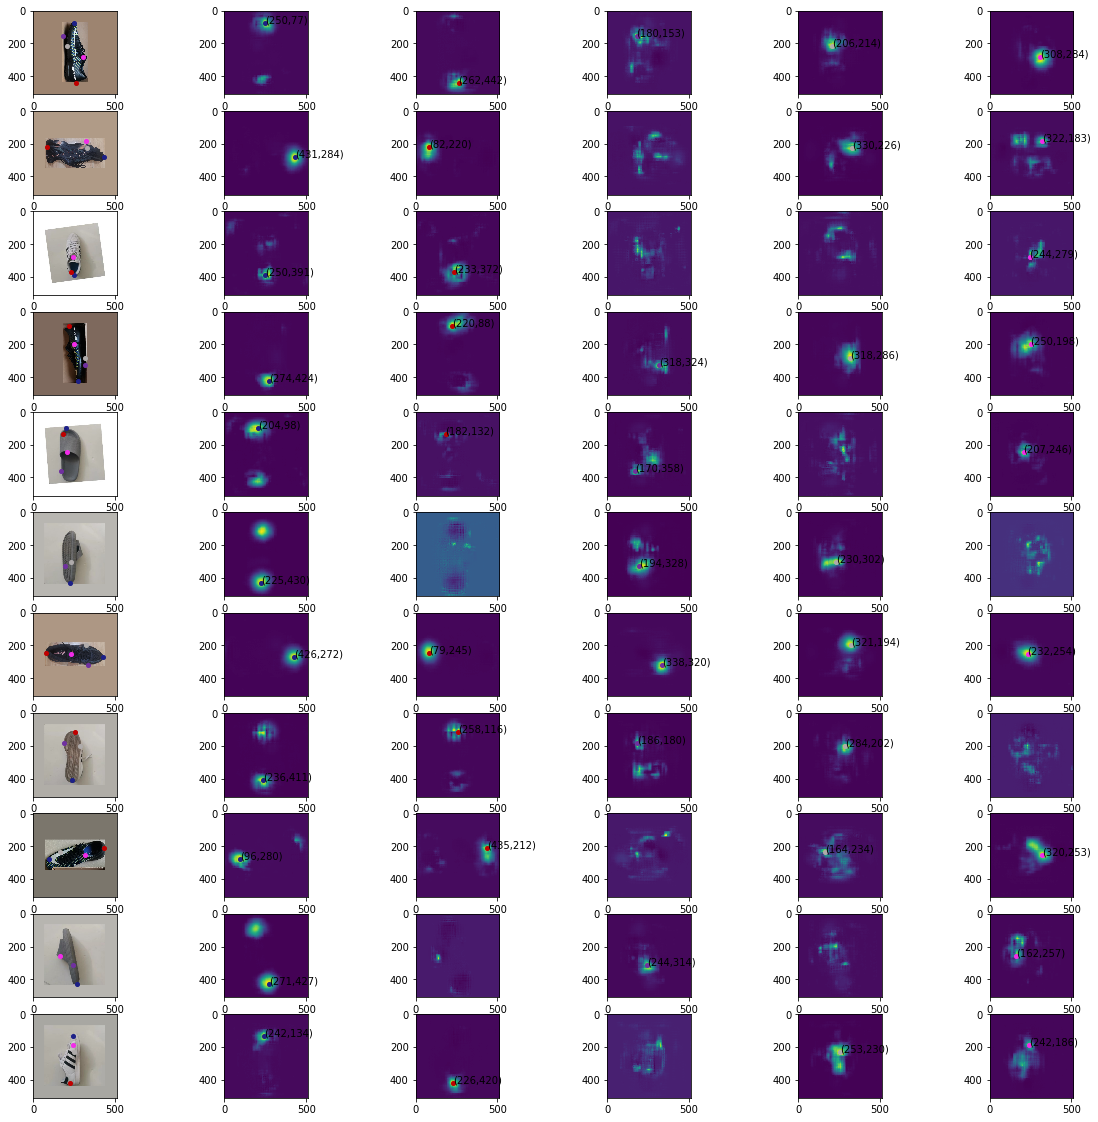

In [45]:
# Inference should implement the reverse process of data augmentation:
# Reverse Processing of Crop Center Square (h,w)→（fh,fw）
# Resize (didn't change the relative position), without Data augmentation when testing
### inference(testing) process, load the model parameters
testset_root2 = "TestingSetSmall"
test_filelists2 = [os.path.join(testset_root2,i) for i in os.listdir(testset_root2)]

def infer(model, val_dataloader): #test_dataset
    model.eval()
    logits = []
    imgs = []
    # cache = []  # ?
    with paddle.no_grad(): 
        # for img, idx, h, w, fh, fw in test_dataset:   # h,w is the original size of img images
        #     img = img[np.newaxis, ...]    
        #     img = paddle.to_tensor((img / 255.).astype("float32"))    
        #     logit = model(img)
            
        #     logits.append(logit)
        #     imgs.append(img)
        #     # pred_coor = logits.numpy()
        for data in val_dataloader:  #  img, idx, h, w, fh, fw
            imgs = (data[0] / 255.).astype("float32")
            logits = model(imgs)

    return logits, imgs


img_test_transforms = trans.Compose([
    trans.PaddedSquare('constant'),  # may use 'edge' mode when testing in real scenes. 
    trans.RandomPadWithoutPoints(pad_thresh_l=0.384, pad_thresh_h=0.384)  # accroding to CropbyBBxinDarknet; # accroding to CropbyBBxinDarknet  pad_thresh_l=0.316, pad_thresh_h=0.412
    # trans.ColorJitter(0.3, 0.3, 0.3, 0.3) 
])

test_dataset = imgDataset(image_file = test_filelists2,  # test_filelists2[0:2] images collected from real scenes
                        # pred_xy=pred_xy,
                       img_transforms = img_test_transforms,
                    #    label_file=None,
                       mode='test')

test_loader = paddle.io.DataLoader(
    test_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(test_dataset, batch_size=len(test_filelists2), shuffle=False, drop_last=False),
    # num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)


# GResNet-Deepest
from grconvnet3deepest_keypoint_paddle import GenerativeResnet_Deepest
model= GenerativeResnet_Deepest(input_channels=3, output_channels=5, channel_size=32,dropout=True, prob=0)

# best_model_path = "trained_models/7Heatmap_GResNet-Deepest_C32_L2_ED_220228_1102/best_model_0.011527/model.pdparams"
best_model_path = "trained_models/8_3Heatmap_GResNet-Deepest_C32_no_TestSet_finetune_220315_1219/best_model_0.016625/model.pdparams"
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)

logits, imgs= infer(model,test_loader)  #test_dataset the size of logits, label is (bacth, output_dims)


### visualize predicted results and corresponding ground truths of Testing Images
# the size of logits, label is (bacth, output_dims)
plt.figure(figsize=(20, 20))
colors = ['#1D2088', '#C00000','#7030A0','#AFABAB', '#F22CE9'] # blue, red, purple, grey, magenta
num =  logits.shape[0] #  len(logits)
# print(num)
for i in range(num):
    img=imgs[i].numpy() # transfer paddle.Tensor to numpy.ndarray
    pre = logits[i]

    plt.subplot(num, 6, 6*i+1)
    plt.imshow(img.transpose(1, 2, 0)) # C, H, W → H, W, C
    
    # visualize the heatmaps
    for j in range(logits.shape[1]):  # logit.shape[1]==5
        plt.subplot(num,6,6*i+j+2)
        # plt.imshow(lab[j])
        plt.imshow(pre[j])
        if pre[j].max() >= 0.3:
            kx_p= np.where(pre[j]==pre[j].max())[1][0]
            ky_p= np.where(pre[j]==pre[j].max())[0][0]

            plt.plot(kx_p, ky_p,'.', color=colors[j], markersize=8)
            plt.text(kx_p, ky_p, "({},{})".format(kx_p,ky_p))
            plt.subplot(num, 6, 6*i+1)
            plt.plot(kx_p, ky_p,'.', color=colors[j], markersize=8)

In [ ]:
# Reverse the 
side_len = max(h,w) 
# Reverse RandomPadWithPoints 
h2 = h - side_len
w2 = w - side_len
pad_top = h2//2
pad_bottom = h2 - pad_top
pad_left = w2//2
pad_right = w2- pad_left
img0 = img[pad_left: w-pad_right][pad_top:h-pad_bottom]


plt.figure(figsize=(20, 20))
colors = ['#1D2088', '#C00000','#7030A0','#AFABAB', '#F22CE9'] # blue, red, purple, grey, magenta
num =  logit.shape[0] # 8
for i in range(num):
    img=imgs[i].numpy() # transfer paddle.Tensor to numpy.ndarray
    pre = logits[i]

    plt.subplot(num, 6, 6*i+1)
    plt.imshow(img.transpose(1, 2, 0)) # C, H, W → H, W, C
    
    # visualize the heatmaps
    for j in range(logits.shape[1]):  # logit.shape[1]==5
        plt.subplot(num,6,6*i+j+2)
        # plt.imshow(lab[j])
        plt.imshow(pre[j])
        if pre[j].max() >= 0.1:
            kx_p= np.where(pre[j]==pre[j].max())[1][0]
            ky_p= np.where(pre[j]==pre[j].max())[0][0]

            plt.plot(kx_p, ky_p,'.', color=colors[j], markersize=8)
            plt.text(kx_p, ky_p, "({},{})".format(kx_p,ky_p))
            plt.subplot(num, 6, 6*i+1)
            plt.plot(kx_p, ky_p,'.', color=colors[j], markersize=8)


In [30]:
### The img images in the test dataset are localizated one by one

cache = []
for img, idx, h, w, fh, fw in test_dataset:   # h,w is the original size of img images
    img = img[np.newaxis, ...]    
    img = paddle.to_tensor((img / 255.).astype("float32"))    
    logits = model(img)
    pred_coor = logits.numpy()
    # print(pred_coor)

    # fw, fh =1024, 1024 # for lcoal center square cropping
    # fh, fw = min(img_h, img_w), min(img_h, img_w)    # for global center square cropping

    # map to the orignal image cooridinate system
    fx = pred_coor[0][0] * fw  # fx = fx_nor * fw 
    fy = pred_coor[0][1] * fh
    x= fx + (w-fw)/2     # x, y is the absolute coordinate in original images
    y= fy + (h-fh)/2  
    cache.append([idx[-8:-4], x, y])

### save the predicted results in .csv file
submission_result = pd.DataFrame(cache, columns=['data', 'Fovea_X', 'Fovea_Y'])
submission_result[['data', 'Fovea_X', 'Fovea_Y']].to_csv("./Localization_Results.csv", index=False)

In [28]:
pd.read_csv('Localization_Results.csv', converters = {'data':str})

data      Fovea_X      Fovea_Y
0   0101  1495.963013  1034.208252
1   0102  1476.907043  1039.170166
2   0103  1467.928314  1067.151367
3   0104  1493.119690  1007.654114
4   0105  1628.232483  1060.307495
..   ...          ...          ...
95  0196  1477.824249  1027.706238
96  0197  1308.738190  1096.563599
97  0198  1647.205566  1099.223145
98  0199  1474.260101  1050.359497
99  0200  1490.574829  1052.467529

[100 rows x 3 columns]

# Deployment
## Deploy pose classification and keypoint detection algorithms

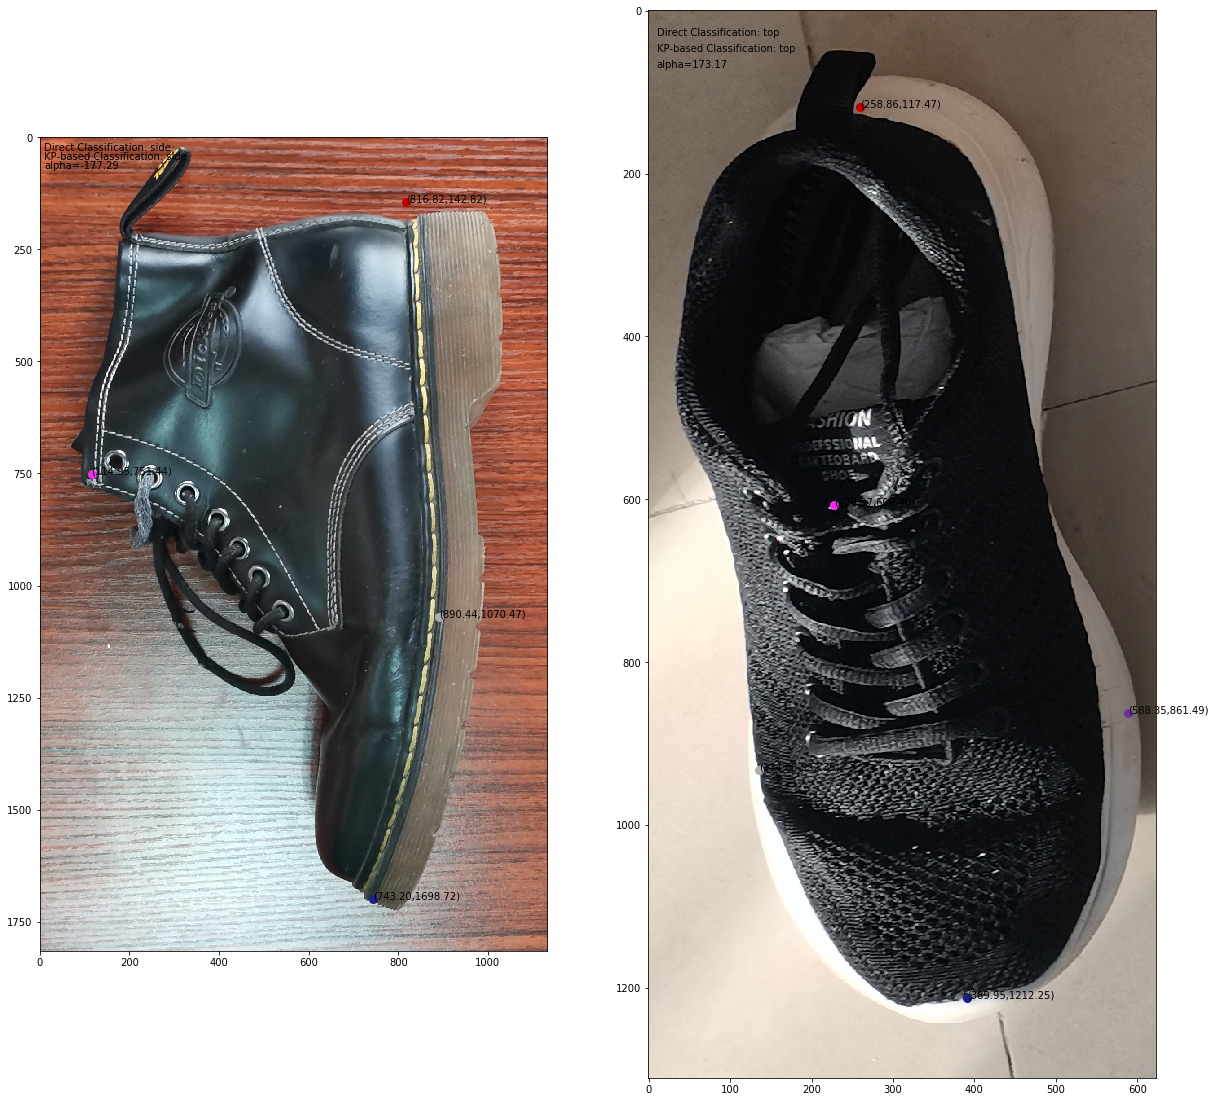

In [6]:
import sys 
sys.path.append('/home/aistudio/external-libraries')
import cv2
#import random
#import numpy as np
#import pandas as pd
import matplotlib.pylab as plt  # For interactive coding, e.g., Notebook
# import matplotlib.pyplot as plt # For (non-interactive) scripts

### custom modules
from models.resnet34_classification_paddle import Model_resnet34
from models.keypointnet_deepest_paddle import KeypointNet_Deepest # GResNet-Deepest
from inference.config import test_filelists2, infer_mode, best_PCmodel_path,best_PCmodel_path2,best_KPmodel_path #,PC_transforms,KP_transforms
from inference.keypoints_pred import get_trained_model, PCinfer, KPinfer


## make Keypoints.msg, Keypoint.msg (confidence/probability,x,y,String state), ShoeStates.msg/ShoePoseClass.msg in KD_ros/KD_ros_msgs/msg
### considering the extensibility, use a keypoints[] class array instead of an array/list consists of all the info of keypoints 

#import argparse
#def parse_args():
#    parser = argparse.ArgumentParser(description='Train network')
#
#    # Network
#    parser.add_argument('--network', type=str, default='grconvnet3',
#                        help='Network name in inference/models')
#    args = parser.parse_args()
#    return args


if __name__ == '__main__': # avoid automatic running below lines when this .py file is imported by others.    
    ### image subscriber 
    if infer_mode == 'test':     # test_filelists2 is an image name list when self.mode == "test"
        test_filelists2 = ['TestingSet/IMG_20210302_151345.jpg', 'TestingSet/IMG_20211207_114000.jpg']
    elif infer_mode == 'deploy': # test_filelists2 is an image list when self.mode == "deploy"
        test_filelists2 =  [cv2.imread(i) for i in ['TestingSet/IMG_20211207_144827_1.jpg', 'TestingSet/IMG_20210302_155456.jpg']]
    else:
        print('The model %s is to be updated soon.'%infer_mode)
        
    batchsize = len(test_filelists2)
    
    
    '''
    ### Loading Direct State Classification model v1
    best_PCmodel_path  = "trained_models/ShoePoseClassificationResNet/PC_ResNet34_0.9812.pdparams" # 0.5*0.9812 + 0.5*0.9801
    best_PCmodel_path2 = "trained_models/ShoePoseClassificationResNet/PC_ResNet34_0.9801.pdparams" # 0.5*0.9812 + 0.5*0.9801 
    PCmodel = Model_resnet34()
    PC_para_state_dict = paddle.load(best_PCmodel_path)
    PCmodel.set_state_dict(PC_para_state_dict)
    # PCmodel2= None
    PCmodel2= Model_resnet34()
    PC_para_state_dict2 = paddle.load(best_PCmodel_path2)
    PCmodel2.set_state_dict(PC_para_state_dict2)
    '''
    ### Loading Direct State Classification model v2
    PCmodel = Model_resnet34()
    PCmodel = get_trained_model(PCmodel, best_PCmodel_path)
    if best_PCmodel_path2 == '' or best_PCmodel_path2 == None:
        PCmodel2= None
    else:
        PCmodel2= Model_resnet34()
        PCmodel2= get_trained_model(PCmodel2,best_PCmodel_path2)
    
    ### Infer state class
    state_classes =PCinfer(PCmodel,PCmodel2, test_filelists2)
    
    
    '''
    ### Loading keypoint detection model v1
    KPmodel= KeypointNet_Deepest(input_channels=3, output_channels=5, channel_size=32,dropout=True, prob=0)
    best_KPmodel_path = "trained_models/8_3Heatmap_GResNet-Deepest_C32_no_TestSet_finetune_220315_1219/best_model_0.016625/model.pdparams"
    #best_KPmodel_path = "trained_models/2DShoeKeypointDetection/2DKeypointNet_0.016625.pdparams"
    KP_para_state_dict = paddle.load(best_KPmodel_path)
    KPmodel.set_state_dict(KP_para_state_dict)
    '''
    ### Loading keypoint detection model v2
    KPmodel= KeypointNet_Deepest(input_channels=3, output_channels=5, channel_size=32,dropout=True, prob=0)
    KPmodel= get_trained_model(KPmodel, best_KPmodel_path)
    
    ### Infer keypoints with confidence in the format of [toe_c, toe_x, toe_y, heel_c ...,  inside ..., outside ..., topline ... ] 
    confident_kps, orientations, states= KPinfer(KPmodel,test_filelists2, orient_mode =True, state_mode = True)  #the size of confident_kps is CroppeedImg num x 15
    

    ### Visualizing predicted Keypoints
    plt.figure(figsize=(20, 20)) # , for matplotlib
    # colors =[(136,32,29), (0,0,192), (160,48,112),(171,171,175),(233,44,242)] # BGR
    colors = ['#1D2088', '#C00000','#7030A0','#AFABAB', '#F22CE9'] # blue, red, purple, grey, magenta, , for matplotlib
    # For RGB, [(29,32,136), (192,0,0), (112,48,160),(175,171,171),(242,44,233)]
    # For BGR, [(136,32,29), (0,0,192), (160,48,112),(171,171,175),(233,44,242)]
    shoe_states= ['top','side','bottom'] # 0,1,2 represents top, side, bottom state respectively
    keypoint_classes =  ['toe','heel','inside','outside','topline']
    for i in range(batchsize):
        if infer_mode == 'test':
            img =  cv2.imread(test_filelists2[i])[:, :, ::-1]
        elif infer_mode == 'deploy':
            img= test_filelists2[i][:, :, ::-1] # BGR -> RGB, , for matplotlib
        else:
            print('The model %s is to be updated soon'%infer_mode)
        
        # Matplotlib visulization
        plt.subplot(1,batchsize,i+1)
        plt.imshow(img)
        for j in range(confident_kps.shape[1]//3):
            if confident_kps[i][3*j]>0.5:
                plt.plot(confident_kps[i][3*j+1]+0.5,confident_kps[i][3*j+2]+0.5,'.', color=colors[j], markersize=16) # +0.5 means centre of pixel
                plt.text(confident_kps[i][3*j+1]+0.5,confident_kps[i][3*j+2]+0.5, "({:.2f},{:.2f})".format(confident_kps[i][3*j+1],confident_kps[i][3*j+2]))
                
        plt.text(10, 30, 'Direct Classification: %s'%shoe_states[state_classes[i]])
        plt.text(10, 50, 'KP-based Classification: %s'%shoe_states[states[i]])
        plt.text(10, 70, 'alpha=%.2f'%orientations[i][0]) # str(round(orientations[i][0],2))
        
        '''
        # opencv visualization
        for j in range(confident_kps.shape[1]//3):
            if confident_kps[i][3*j]>0.5:
                img =cv2.circle(img, (round(confident_kps[i][3*j+1]), round(confident_kps[i][3*j+2])), 8, colors[j], -1)
                img=cv2.putText(img, keypoint_classes[j], (round(confident_kps[i][3*j+1]), round(confident_kps[i][3*j+2])), cv2.FONT_HERSHEY_SIMPLEX , 1, colors[j], 2, cv2.LINE_AA)
        img=cv2.putText(img, states[state_classes[i]], (10, 50), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), 2, cv2.LINE_AA)
        img=cv2.putText(img, str(round(orientations[i][0],2)), (10, 70), cv2.FONT_HERSHEY_SIMPLEX , 1, (0,255,0), 2, cv2.LINE_AA)
        # print(type(img))
        #cv2.namedWindow("image %d"%i)
        # cv2.imshow("image %d"%i, img)
        cv2.imshow("image",img)
        #cv2.waitKey(4000)
        while (cv2.waitKey(3000)==27):
            pass
        #cv2.destroyAllWindows()
        '''
        ### TO DO -  state class-based keypoint outputs

In [10]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


# Summary